In [149]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

# For each variable of each system, generate time series:
# -of cadence = 0.01, 0.05, 0.1 * quasi-period
# -of length N_cycles = 5, 10, 50 quasi-periods
# -3 versions each

# = 27 arrays per variable
# = 81 arrays per 3D system.

In [2]:
cadences = np.array((0.01, 0.05, 0.1))
Ncyc = np.array((5,10,50))

### Gaussian noise

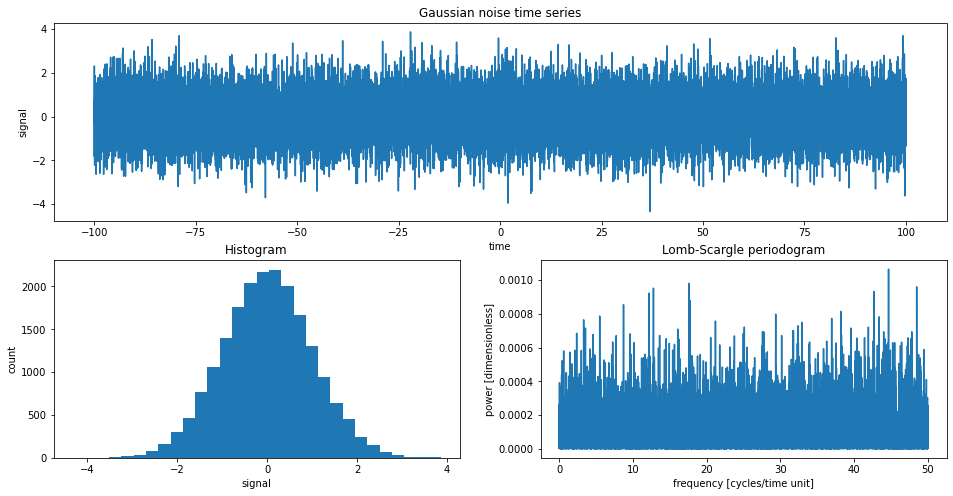

In [3]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
sp.plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

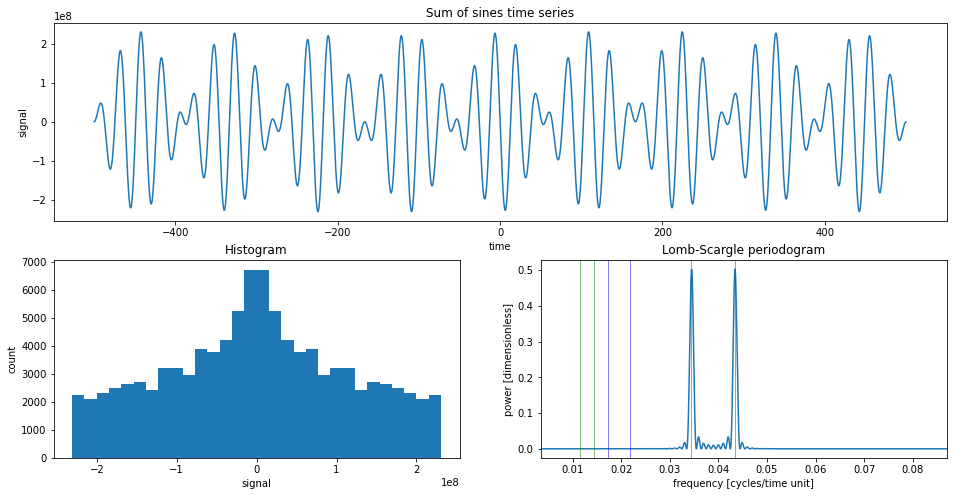

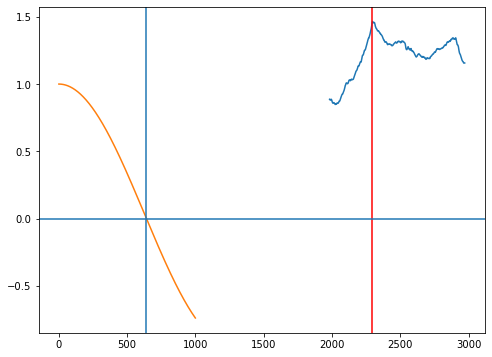

22.96


'\nfor N in Ncyc:\n    for c in cadences:\n        #print("c is {0}".format(c))\n        #print("N is {0}".format(N))\n        cad = c * qp_t\n        Npoints = (qp_t * N)/cad\n        \n        t = np.arange(0, qp_t*N, cad)\n        simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))\n        simplePeriodic = simplePeriodic/np.mean(simplePeriodic)\n        \n        #fig, ax = plt.subplots(1,1,figsize=(10,4))\n        #ax.plot(t, simplePeriodic, \'k.\')\n        #plt.show()\n        np.save("./corrDimTesting/simplePeriodic_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),simplePeriodic)\n        np.save("./corrDimTesting/simplePeriodic_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)\n'

In [4]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
sp.plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
               true_freq=trueFreqs,title="Sum of sines")

qp = sp.estimateQuasiPeriod(t, simplePeriodic, plot=True) # in units of test cadence, dt = 0.01
qp_t = qp * dt
print(qp_t)
"""
for N in Ncyc:
    for c in cadences:
        #print("c is {0}".format(c))
        #print("N is {0}".format(N))
        cad = c * qp_t
        Npoints = (qp_t * N)/cad
        
        t = np.arange(0, qp_t*N, cad)
        simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
        simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
        
        #fig, ax = plt.subplots(1,1,figsize=(10,4))
        #ax.plot(t, simplePeriodic, 'k.')
        #plt.show()
        np.save("./corrDimTesting/simplePeriodic_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),simplePeriodic)
        np.save("./corrDimTesting/simplePeriodic_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)
"""

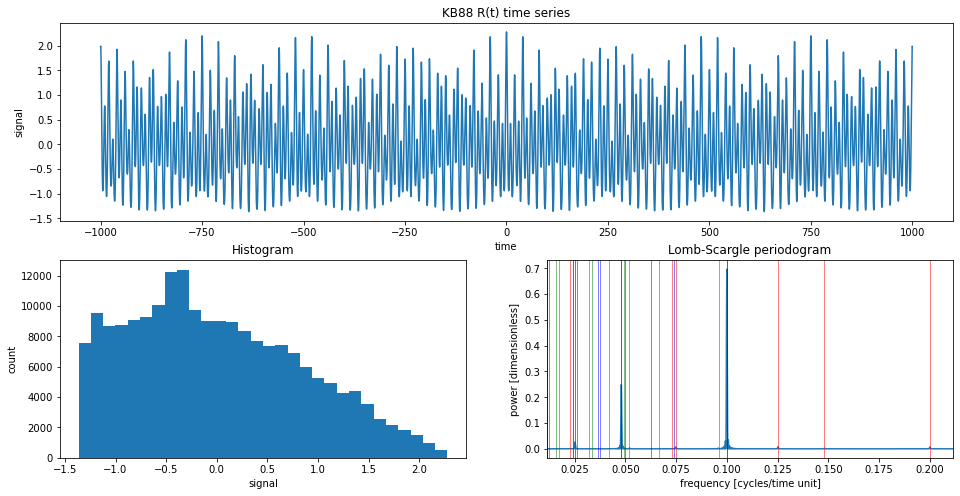

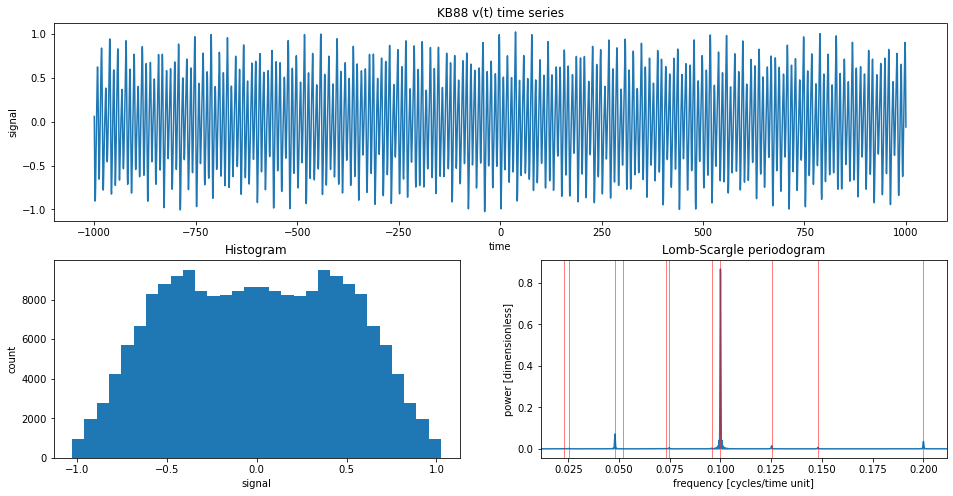

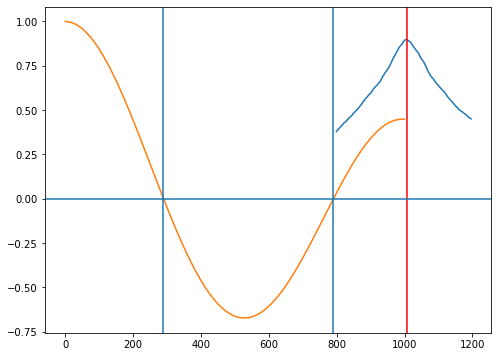

10.06


'\nfor N in Ncyc:\n    for c in cadences:\n        #print("c is {0}".format(c))\n        #print("N is {0}".format(N))\n        cad = c * qp_t\n        Npoints = (qp_t * N)/cad\n        \n        t = np.arange(0, qp_t*N, cad)\n        multiPeriodic_r, multiPeriodic_v = sp.KB88(t)\n        \n        #fig, ax = plt.subplots(1,1,figsize=(10,4))\n        #ax.plot(t, multiPeriodic_r, \'k.\')\n        #plt.show()\n        np.save("./corrDimTesting/KB88r_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),multiPeriodic_r)\n        np.save("./corrDimTesting/KB88r_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)\n        \n\ndt = 0.01\ntmin = -1000.\ntmax = 1000.\nbaseline = tmax - tmin\nt = np.arange(tmin,tmax,dt)\n\nmultiPeriodic_r, multiPeriodic_v = sp.KB88(t)\n\nqp = sp.estimateQuasiPeriod(t, multiPeriodic_v, plot=True) # in units of test cadence, dt = 0.01\nqp_t = qp * dt\nprint(qp_t)\n\nfor N in Ncyc:\n    for c in cadences:\n        #print("c is {0}".format

In [5]:
# multi-periodic signal from Kovacs & Buchler 1988
dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

sp.plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
sp.plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")


qp = sp.estimateQuasiPeriod(t, multiPeriodic_r, plot=True) # in units of test cadence, dt = 0.01
qp_t = qp * dt
print(qp_t)
"""
for N in Ncyc:
    for c in cadences:
        #print("c is {0}".format(c))
        #print("N is {0}".format(N))
        cad = c * qp_t
        Npoints = (qp_t * N)/cad
        
        t = np.arange(0, qp_t*N, cad)
        multiPeriodic_r, multiPeriodic_v = sp.KB88(t)
        
        #fig, ax = plt.subplots(1,1,figsize=(10,4))
        #ax.plot(t, multiPeriodic_r, 'k.')
        #plt.show()
        np.save("./corrDimTesting/KB88r_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),multiPeriodic_r)
        np.save("./corrDimTesting/KB88r_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)
        

dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

qp = sp.estimateQuasiPeriod(t, multiPeriodic_v, plot=True) # in units of test cadence, dt = 0.01
qp_t = qp * dt
print(qp_t)

for N in Ncyc:
    for c in cadences:
        #print("c is {0}".format(c))
        #print("N is {0}".format(N))
        cad = c * qp_t
        Npoints = (qp_t * N)/cad
        
        t = np.arange(0, qp_t*N, cad)
        multiPeriodic_r, multiPeriodic_v = sp.KB88(t)
        
        #fig, ax = plt.subplots(1,1,figsize=(10,4))
        #ax.plot(t, multiPeriodic_v, 'k.')
        #plt.show()
        np.save("./corrDimTesting/KB88v_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),multiPeriodic_v)
        np.save("./corrDimTesting/KB88v_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)
"""

### Rossler system 

In [6]:
fp1, fp2 = sp.Rossler_FPs(a=0.2,b=0.2,c=5.7)
print(fp1)
print(fp2)

[  5.6929738  -28.46486898  28.46486898]
[ 0.0070262  -0.03513102  0.03513102]


[ 3.45344022 -1.10983499  0.07186731]


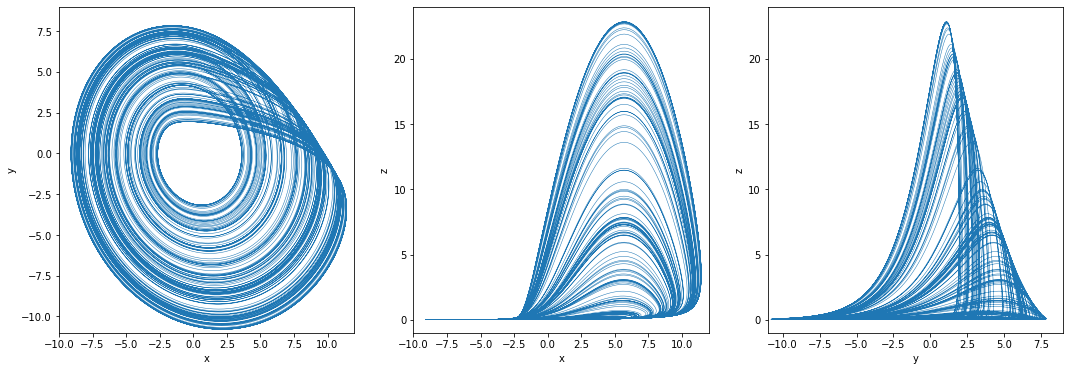

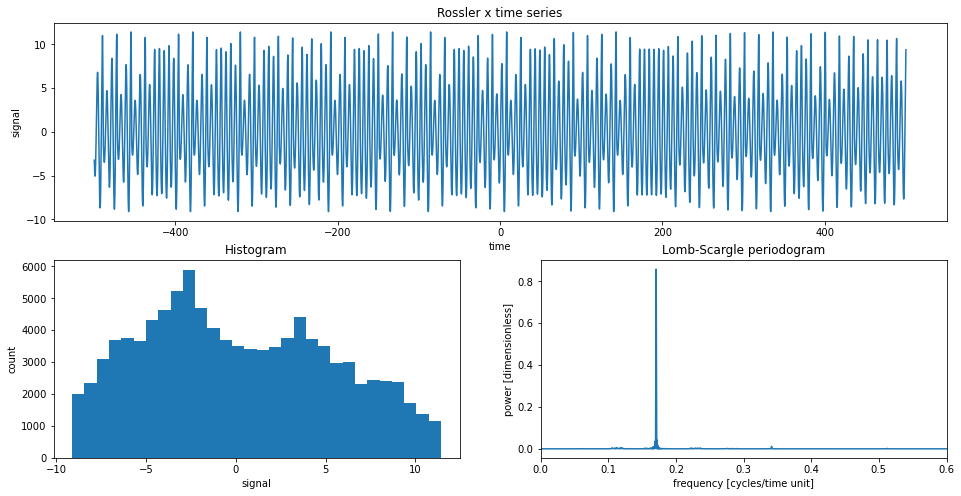

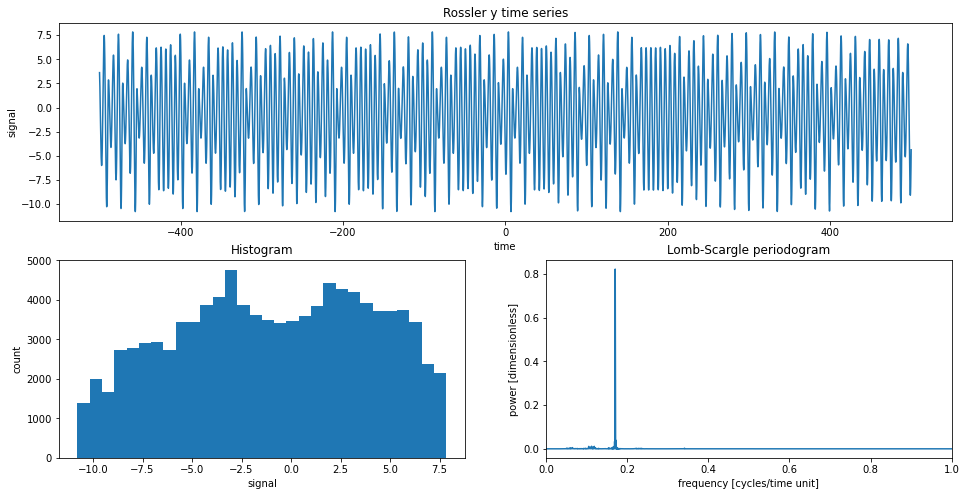

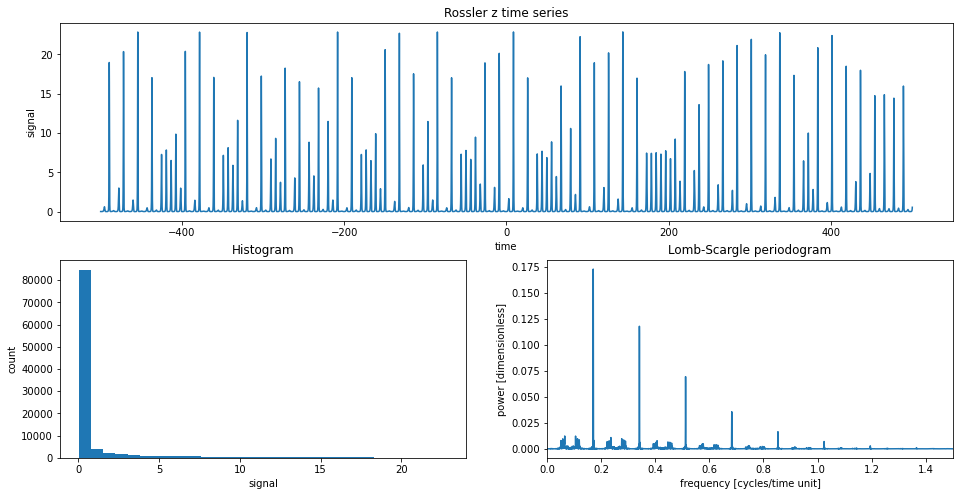

'\n\n#now, for x, y, and z: each cadence, each Ncyc, 3 versions.\nfor i in range(3):\n#for i in range(1):\n    qp = sp.estimateQuasiPeriod(rossler_t, rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01\n    qp_t = qp * dt\n    print(qp_t)\n\n    for N in Ncyc:\n        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator\n        # will choose shorter cadences than I give it in order to maintain accuracy.\n        \n        cad = 0.01 * qp_t\n        Nsteps = int(np.ceil((qp_t * N)/cad))\n        print(Nsteps)\n        \n        for v in range(3):\n            tmin = (qp_t * N)*(v)\n            tmax = (qp_t * N)*(v+1)\n\n            rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax)\n\n            rossler_r_arr = np.atleast_2d(r0)\n            rossler_t_arr = np.array((tmin))\n\n            while rossler.t < tmax:\n                rossler.step()\n                rossler_r_arr = np.v

In [83]:
#r0 = np.array((0.1, -7, 0.1))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-3.19582017,  3.64416763, 0.02384456))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

print(rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-10,12)
axes[0].set_ylim(-11,9)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-10,12)
axes[1].set_ylim(-1,24)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-11,9)
axes[2].set_ylim(-1,24)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
sp.plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
sp.plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

varnames = ['x','y','z']
"""

#now, for x, y, and z: each cadence, each Ncyc, 3 versions.
for i in range(3):
#for i in range(1):
    qp = sp.estimateQuasiPeriod(rossler_t, rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01
    qp_t = qp * dt
    print(qp_t)

    for N in Ncyc:
        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator
        # will choose shorter cadences than I give it in order to maintain accuracy.
        
        cad = 0.01 * qp_t
        Nsteps = int(np.ceil((qp_t * N)/cad))
        print(Nsteps)
        
        for v in range(3):
            tmin = (qp_t * N)*(v)
            tmax = (qp_t * N)*(v+1)

            rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax)

            rossler_r_arr = np.atleast_2d(r0)
            rossler_t_arr = np.array((tmin))

            while rossler.t < tmax:
                rossler.step()
                rossler_r_arr = np.vstack((rossler_r_arr, rossler.y))
                rossler_t_arr = np.vstack((rossler_t_arr, rossler.t))

            rossler_t_arr = rossler_t_arr[0:Nsteps]
            rossler_r_arr = rossler_r_arr[0:Nsteps]
            
            print(np.shape(rossler_t_arr))
            print(np.shape(rossler_r_arr))

            fig, ax = plt.subplots(1,1,figsize=(10,4))
            ax.plot(rossler_t_arr, rossler_r_arr[:,i], 'k.',ms=2)
            ax.plot(rossler_t_arr[::2],rossler_r_arr[::2,i],'r.',ms=5)
            ax.plot(rossler_t_arr[::10],rossler_r_arr[::10,i],'y.',ms=15)
            plt.show()
            
            #np.save("./corrDimTesting/rossler/rossler_{0}_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_r_arr[:,i])
            #np.save("./corrDimTesting/rossler/rossler_{0}_t_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_t_arr)
            
            #np.save("./corrDimTesting/rossler/rossler_{0}_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_r_arr[::2,i])
            #np.save("./corrDimTesting/rossler/rossler_{0}_t_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_t_arr[::2])
              
            #np.save("./corrDimTesting/rossler/rossler_{0}_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_r_arr[::10,i])
            #np.save("./corrDimTesting/rossler/rossler_{0}_t_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_t_arr[::10])
                
            r0 = rossler.y
"""

In [12]:
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t[-15000:-10000],rossler_r[-15000:-10000,0],'k-',lw=2)
#ax.axis("off")
#plt.savefig("./rossler_x_forposter.pdf")

ax.axvline(362.35)
ax.axvline(368.35)
plt.show()

print((368.35-362.35)/0.01)
plt.show()
"""

'\nfig, ax = plt.subplots(1,1,figsize=(16,6))\nax.plot(rossler_t[-15000:-10000],rossler_r[-15000:-10000,0],\'k-\',lw=2)\n#ax.axis("off")\n#plt.savefig("./rossler_x_forposter.pdf")\n\nax.axvline(362.35)\nax.axvline(368.35)\nplt.show()\n\nprint((368.35-362.35)/0.01)\nplt.show()\n'

### Rotated Rossler system (inspired by Letellier & Aguirre 2002)

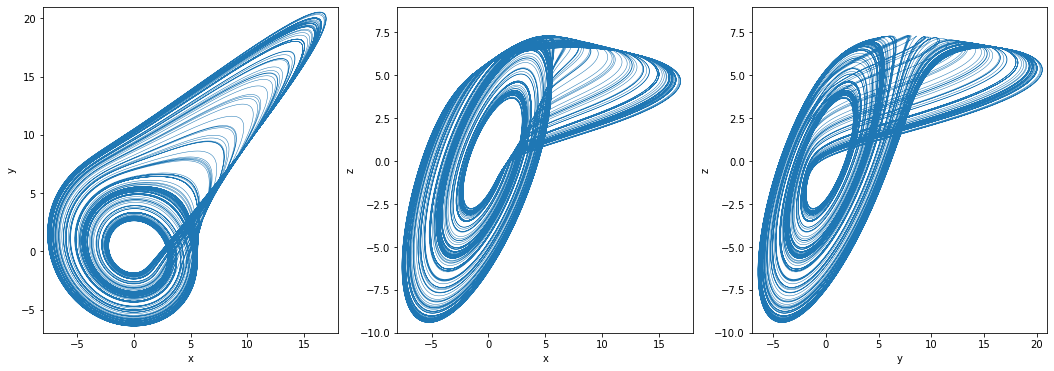

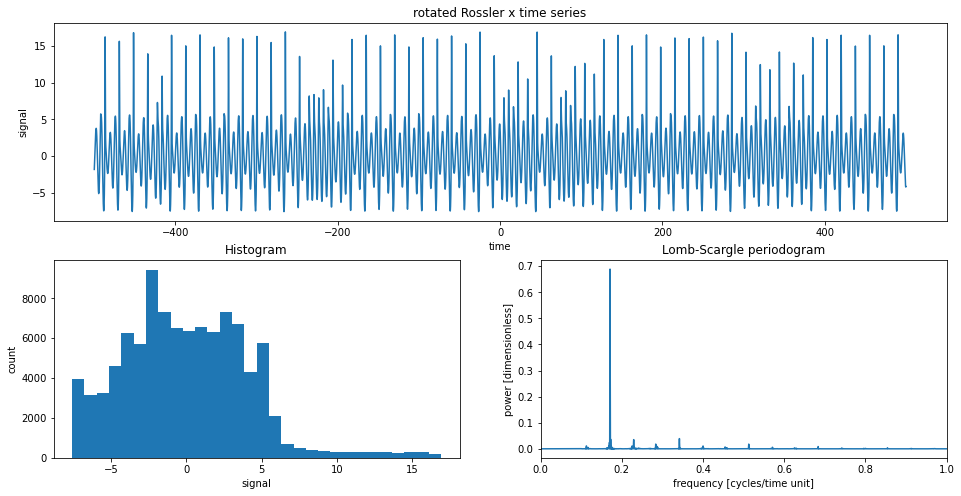

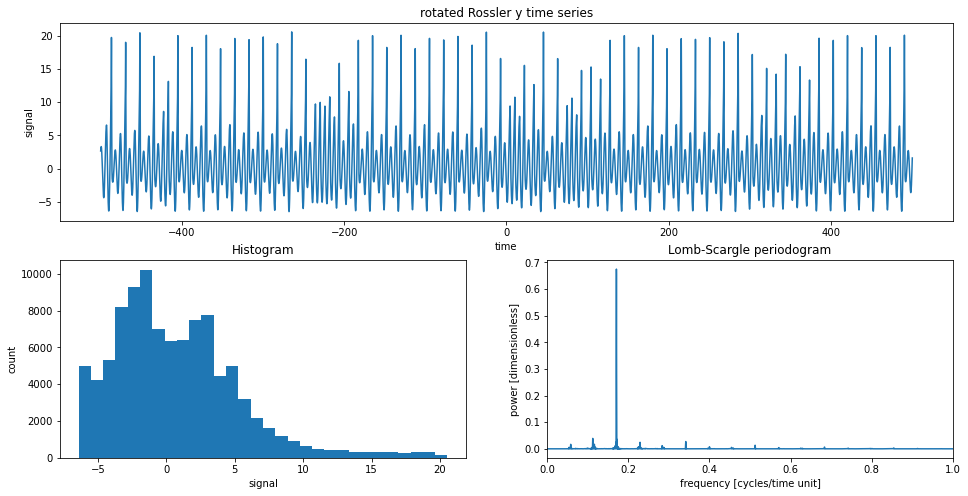

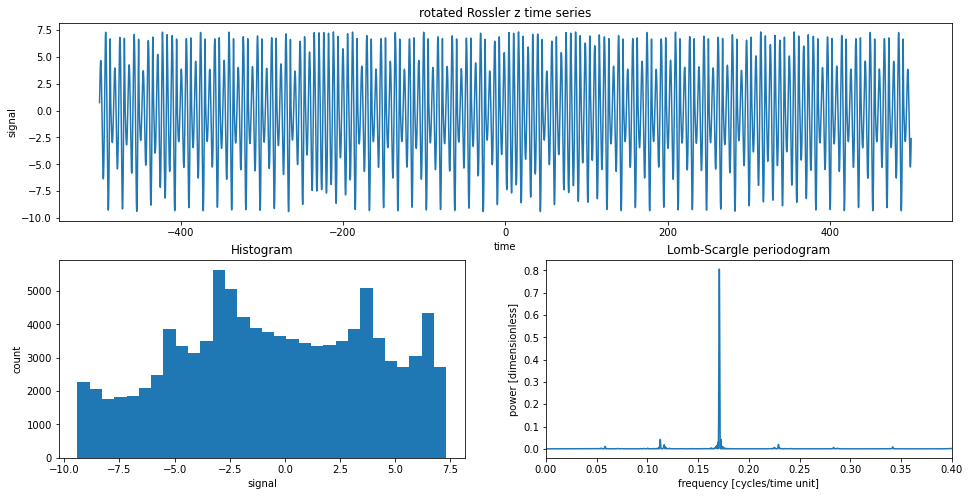

'\n#now, for x, y, and z: each cadence, each Ncyc, 3 versions.\nfor i in range(3):\n#for i in range(1):\n    qp = sp.estimateQuasiPeriod(rotated_rossler_t, rotated_rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01\n    qp_t = qp * dt\n    print(qp_t)\n\n    for N in Ncyc:\n        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator\n        # will choose shorter cadences than I give it in order to maintain accuracy.\n        \n        cad = 0.01 * qp_t\n        Nsteps = int(np.ceil((qp_t * N)/cad))\n        print(Nsteps)\n        \n        for v in range(3):\n            tmin = (qp_t * N)*(v)\n            tmax = (qp_t * N)*(v+1)\n\n            rotated_rossler = RK45(fun=sp.rotated_Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax)\n\n            rotated_rossler_r_arr = np.atleast_2d(r0)\n            rotated_rossler_t_arr = np.array((tmin))\n\n            while rotated_rossler.t < tmax:\n              

In [29]:
#r0 = (1./np.sqrt(2))*np.array((3.6+0.02, 0.02-3.2, -3.2+3.6))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-1.86683832,  2.65479799,  0.69061283))

# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))



dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rotated_rossler = RK45(fun=sp.rotated_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rotated_rossler_r = np.empty((Nsteps,3))
rotated_rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rotated_rossler.step()
    rotated_rossler_t[i] = rotated_rossler.t
    rotated_rossler_r[i] = rotated_rossler.y
    #print(i, rotated_rossler_r[i])
#print(rotated_rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-8,18)
axes[0].set_ylim(-7,21)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-8,18)
axes[1].set_ylim(-10,9)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rotated_rossler_r[:,1],rotated_rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-7,21)
axes[2].set_ylim(-10,9)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler x")
sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler y")
sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,0.4),title="rotated Rossler z")

varnames = ['x','y','z']
"""
#now, for x, y, and z: each cadence, each Ncyc, 3 versions.
for i in range(3):
#for i in range(1):
    qp = sp.estimateQuasiPeriod(rotated_rossler_t, rotated_rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01
    qp_t = qp * dt
    print(qp_t)

    for N in Ncyc:
        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator
        # will choose shorter cadences than I give it in order to maintain accuracy.
        
        cad = 0.01 * qp_t
        Nsteps = int(np.ceil((qp_t * N)/cad))
        print(Nsteps)
        
        for v in range(3):
            tmin = (qp_t * N)*(v)
            tmax = (qp_t * N)*(v+1)

            rotated_rossler = RK45(fun=sp.rotated_Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax)

            rotated_rossler_r_arr = np.atleast_2d(r0)
            rotated_rossler_t_arr = np.array((tmin))

            while rotated_rossler.t < tmax:
                rotated_rossler.step()
                rotated_rossler_r_arr = np.vstack((rotated_rossler_r_arr, rotated_rossler.y))
                rotated_rossler_t_arr = np.vstack((rotated_rossler_t_arr, rotated_rossler.t))

            rotated_rossler_t_arr = rotated_rossler_t_arr[0:Nsteps]
            rotated_rossler_r_arr = rotated_rossler_r_arr[0:Nsteps]
            
            print(np.shape(rotated_rossler_t_arr))
            print(np.shape(rotated_rossler_r_arr))

            fig, ax = plt.subplots(1,1,figsize=(10,4))
            ax.plot(rotated_rossler_t_arr, rotated_rossler_r_arr[:,i], 'k.',ms=2)
            ax.plot(rotated_rossler_t_arr[::2],rotated_rossler_r_arr[::2,i],'r.',ms=5)
            ax.plot(rotated_rossler_t_arr[::10],rotated_rossler_r_arr[::10,i],'y.',ms=15)
            plt.show()
            
            #np.save("./corrDimTesting/rotated_rossler/rotated_rossler_{0}_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rotated_rossler_r_arr[:,i])
            #np.save("./corrDimTesting/rotated_rossler/rotated_rossler_{0}_t_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rotated_rossler_t_arr)
            
            #np.save("./corrDimTesting/rotated_rossler/rotated_rossler_{0}_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rotated_rossler_r_arr[::2,i])
            #np.save("./corrDimTesting/rotated_rossler/rotated_rossler_{0}_t_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rotated_rossler_t_arr[::2])
              
            #np.save("./corrDimTesting/rotated_rossler/rotated_rossler_{0}_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rotated_rossler_r_arr[::10,i])
            #np.save("./corrDimTesting/rotated_rossler/rotated_rossler_{0}_t_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rotated_rossler_t_arr[::10])
                
            r0 = rotated_rossler.y
"""

### Lorenz system

In [ ]:
fp1, fp2 = sp.Lorenz_FPs(sigma=10., beta=8./3., rho=28.)
print(fp1)
print(fp2)

unstable
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


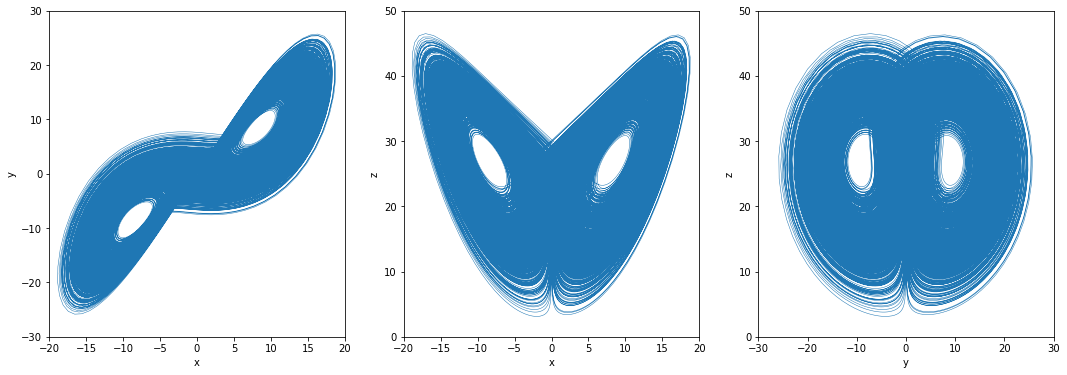

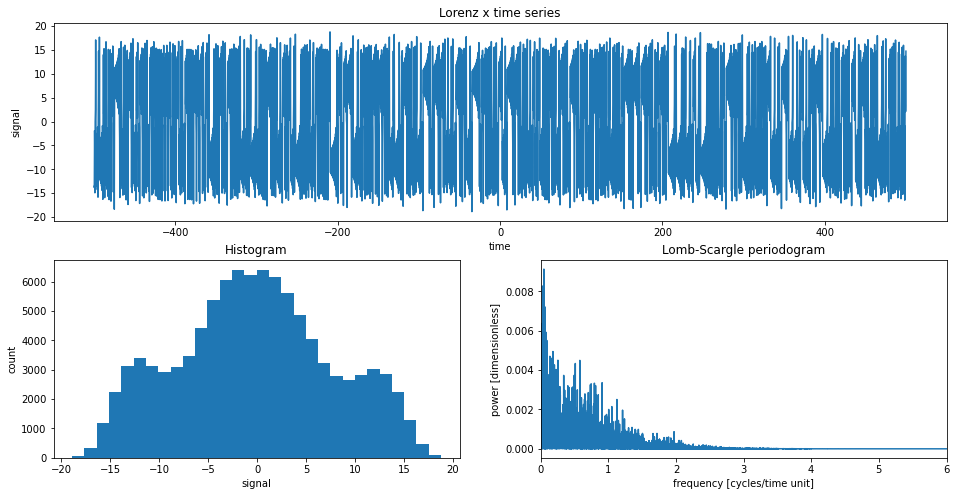

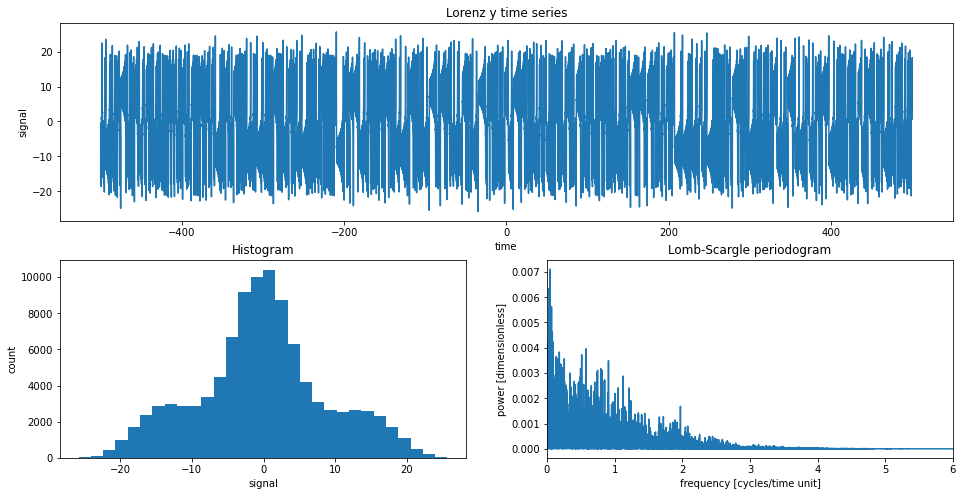

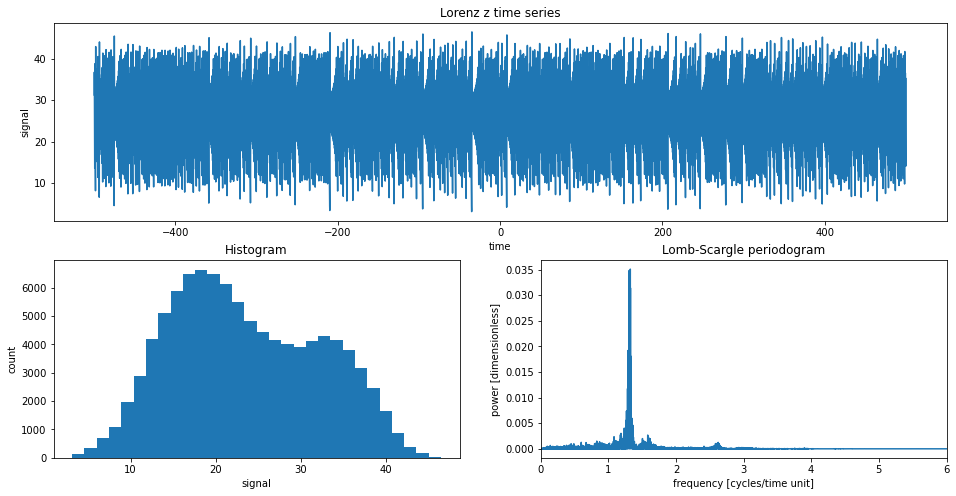

'\n#now, for x, y, and z: each cadence, each Ncyc, 3 versions.\nfor i in range(3):\n#for i in range(1):\n    qp = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,i], plot=True) # in units of test cadence, dt = 0.01\n    qp_t = qp * dt\n    print(qp_t)\n\n    for N in Ncyc:\n        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator\n        # will choose shorter cadences than I give it in order to maintain accuracy.\n        \n        cad = 0.01 * qp_t\n        Nsteps = int(np.ceil((qp_t * N)/cad))\n        print(Nsteps)\n        \n        for v in range(3):\n            tmin = (qp_t * N)*(v)\n            tmax = (qp_t * N)*(v+1)\n\n            lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax)\n\n            lorenz_r_arr = np.atleast_2d(r0)\n            lorenz_t_arr = np.array((tmin))\n\n            while lorenz.t < tmax:\n                lorenz.step()\n                lorenz_r_arr = np.vstack((lore

In [183]:
#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))


#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((Nsteps,3))
lorenz_t = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y


fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(lorenz_t,lorenz_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz y")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz z")

varnames=['x','y','z']
"""
#now, for x, y, and z: each cadence, each Ncyc, 3 versions.
for i in range(3):
#for i in range(1):
    qp = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,i], plot=True) # in units of test cadence, dt = 0.01
    qp_t = qp * dt
    print(qp_t)

    for N in Ncyc:
        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator
        # will choose shorter cadences than I give it in order to maintain accuracy.
        
        cad = 0.01 * qp_t
        Nsteps = int(np.ceil((qp_t * N)/cad))
        print(Nsteps)
        
        for v in range(3):
            tmin = (qp_t * N)*(v)
            tmax = (qp_t * N)*(v+1)

            lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax)

            lorenz_r_arr = np.atleast_2d(r0)
            lorenz_t_arr = np.array((tmin))

            while lorenz.t < tmax:
                lorenz.step()
                lorenz_r_arr = np.vstack((lorenz_r_arr, lorenz.y))
                lorenz_t_arr = np.vstack((lorenz_t_arr, lorenz.t))

            lorenz_t_arr = lorenz_t_arr[0:Nsteps]
            lorenz_r_arr = lorenz_r_arr[0:Nsteps]
            
            print(np.shape(lorenz_t_arr))
            print(np.shape(lorenz_r_arr))

            fig, ax = plt.subplots(1,1,figsize=(10,4))
            ax.plot(lorenz_t_arr, lorenz_r_arr[:,i], 'k.',ms=2)
            ax.plot(lorenz_t_arr[::2],lorenz_r_arr[::2,i],'r.',ms=5)
            ax.plot(lorenz_t_arr[::10],lorenz_r_arr[::10,i],'y.',ms=15)
            plt.show()
            
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_r_arr[:,i])
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_t_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_t_arr)
            
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_r_arr[::2,i])
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_t_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_t_arr[::2])
              
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_r_arr[::10,i])
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_t_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_t_arr[::10])
               
            r0 = lorenz.y
"""

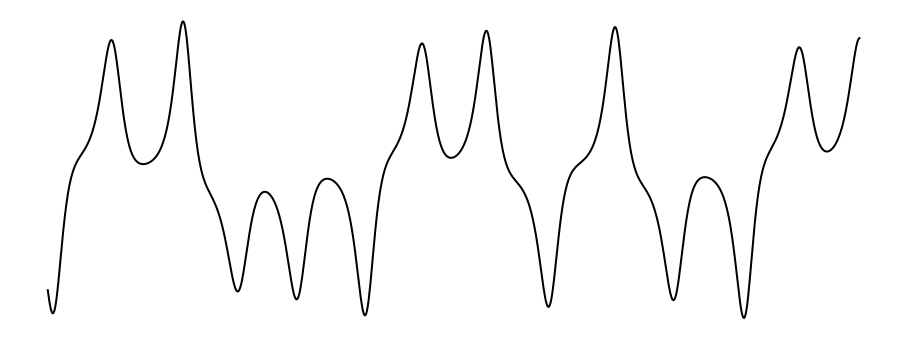

In [81]:
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t[-1000:],lorenz_r[-1000:,0],'k-',lw=2)
ax.axis("off")
plt.savefig("./lorenz_x_forposter.pdf")
"""

### testing a way to estimate the cycle period, based on measuring the median interval between successive local extrema, then refining based on local max of mutual info

In [13]:
"""
qp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,0],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,1],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,2],plot=True)
print(qp)

qp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,0],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,1],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,2],plot=True)
print(qp)

qp = sp.estimateQuasiPeriod(time=rotated_rossler_t[:],timeSeries=rotated_rossler_r[:,0],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=rotated_rossler_t[:],timeSeries=rotated_rossler_r[:,1],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=rotated_rossler_t[:],timeSeries=rotated_rossler_r[:,2],plot=True)
print(qp)
"""

'\nqp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,0],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,1],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,2],plot=True)\nprint(qp)\n\nqp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,0],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,1],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,2],plot=True)\nprint(qp)\n\nqp = sp.estimateQuasiPeriod(time=rotated_rossler_t[:],timeSeries=rotated_rossler_r[:,0],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=rotated_rossler_t[:],timeSeries=rotated_rossler_r[:,1],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=rotated_rossler_t[:],timeSeries=rotated_rossler_r[:,2],plot=True)\nprint(qp)\n'

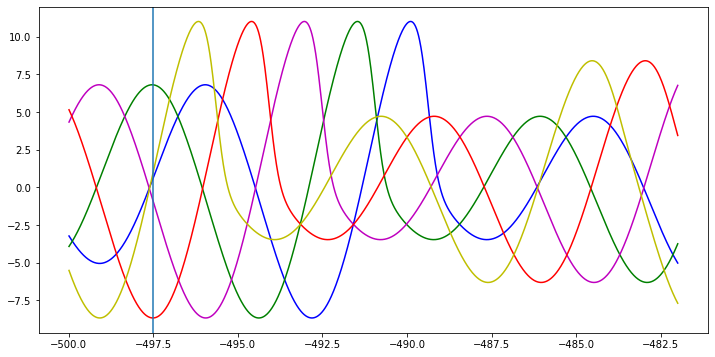

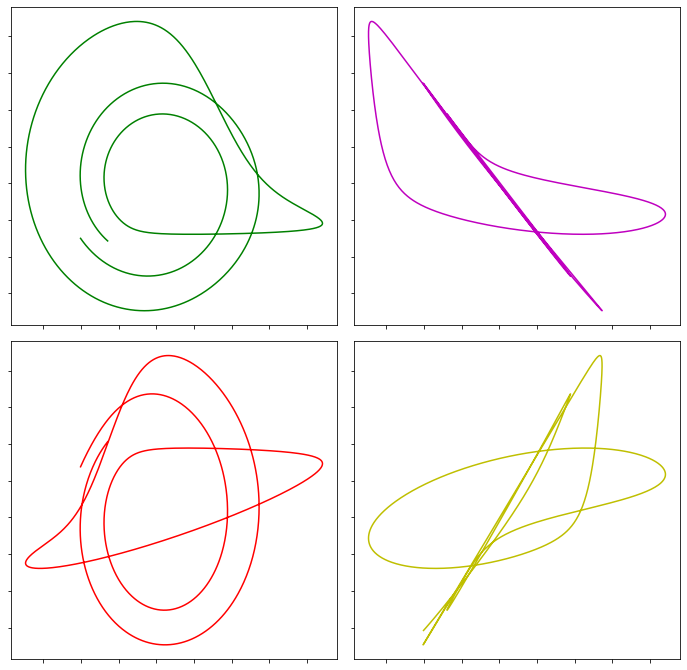

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(rossler_t[0:1800],rossler_r[0:1800,0],color='b')
ax.plot(rossler_t[0:1800],rossler_r[157:1800+157,0],color='g') # +1/4 quasi-period = 1st local min of MI, 1st zero of autocorr. fn
ax.plot(rossler_t[0:1800],rossler_r[314:1800+314,0],color='m') # +1/2 quasi-period = 1st local max of MI, autocorr fn = -1
ax.plot(rossler_t[0:1800],rossler_r[470:1800+470,0],color='r') # +3/4 quasi-period = 2nd local min of MI, 2nd zero of autocorr. fn
ax.plot(rossler_t[0:1800],rossler_r[627:1800+627,0],color='y') #   +1 quasi-period = 2nd local max of MI, autocorr fn = +1
ax.axvline(-497.5)
plt.show()

fig, axes = plt.subplots(2,2,figsize=(12,12))
#axes[0].plot(rossler_r[0:1800,0],rossler_r[0:1800,0],'b')
axes[0,0].plot(rossler_r[0:1800,0],rossler_r[157:1800+157,0],'g')
axes[0,1].plot(rossler_r[0:1800,0],rossler_r[314:1800+314,0],'m')
axes[1,0].plot(rossler_r[0:1800,0],rossler_r[470:1800+470,0],'r')
axes[1,1].plot(rossler_r[0:1800,0],rossler_r[627:1800+627,0],'y')
for ax in np.ravel(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

In [ ]:
# first or second minimum = first or negative first! positive or negative delay time.

## Number of data points 

In [13]:
print(np.shape(rossler_t))
print(np.shape(rossler_r))

(100000,)
(100000, 3)


In [14]:
print(np.shape(rotated_rossler_t))
print(np.shape(rotated_rossler_r))

(100000,)
(100000, 3)


In [15]:
print(np.shape(lorenz_t))
print(np.shape(lorenz_r))

(100000,)
(100000, 3)


# Choose time delay

### Fraser & Swinney 1986 (used 32,768 points for the Belousov-Zhabotinskii rxn; 1,048,576 points for the Rossler system)

### note: keep track of time taken per choice of delay time

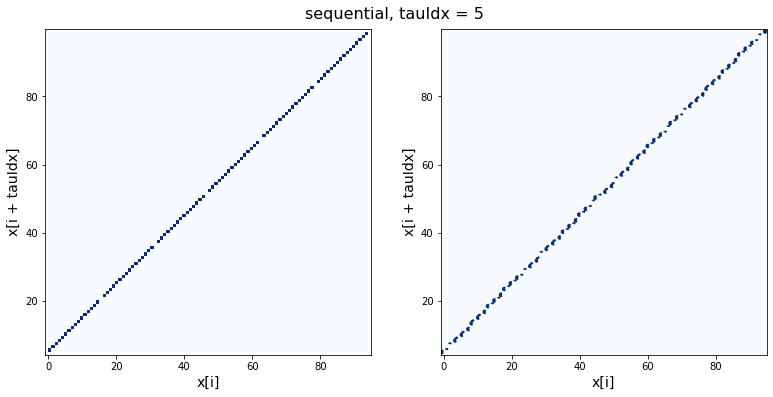

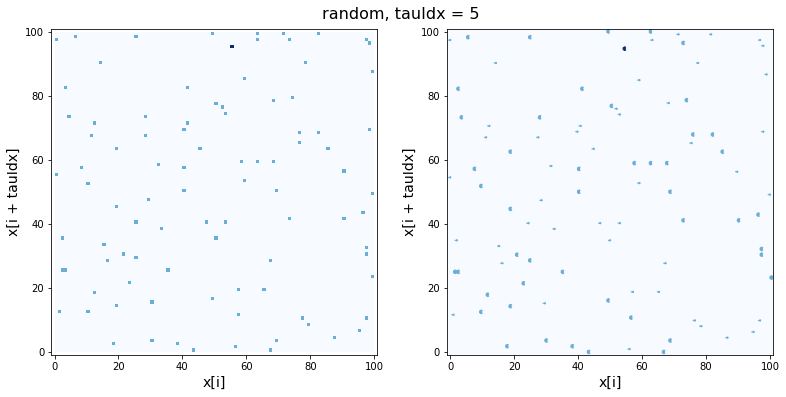

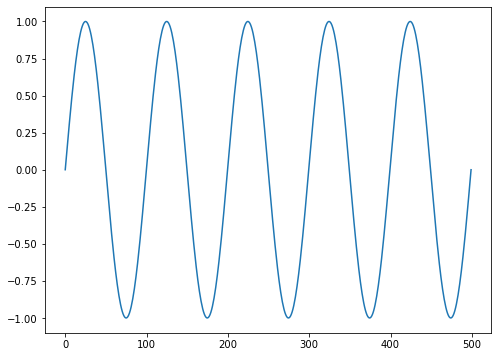

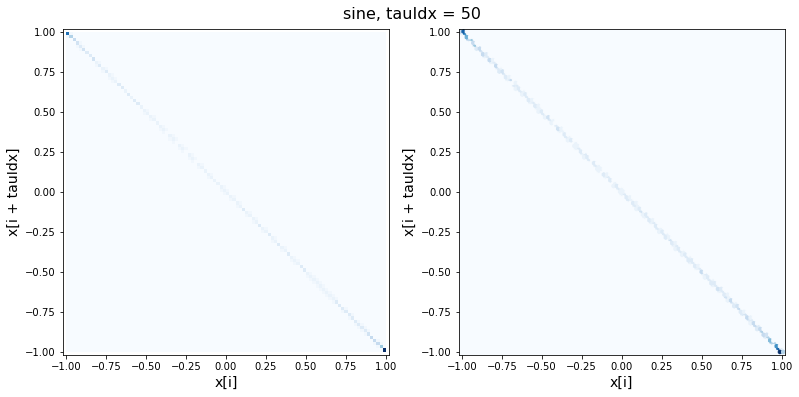

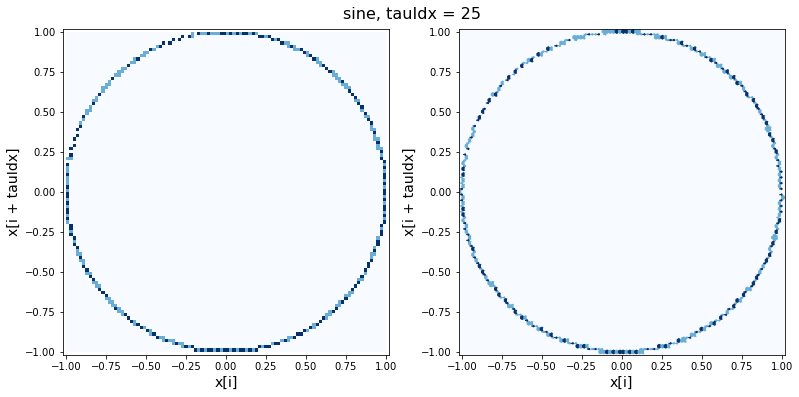

In [19]:
# test cases:
# sequential array
sp.bin2D(timeSeries=np.arange(100),tauIdx=5,plotTitle="sequential, tauIdx = 5")
# random array
sp.bin2D(timeSeries=np.random.randint(0,101,100),tauIdx=5,plotTitle="random, tauIdx = 5")
# correlated array
corr_arr = np.sin(np.linspace(0.,10.*np.pi,500))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(corr_arr)
plt.show()
sp.bin2D(timeSeries=corr_arr, tauIdx = 50, plotTitle="sine, tauIdx = 50") # non-optimal! 
sp.bin2D(timeSeries=corr_arr, tauIdx = 25, plotTitle="sine, tauIdx = 25") # optimal! 50*n = perfect linear correlation

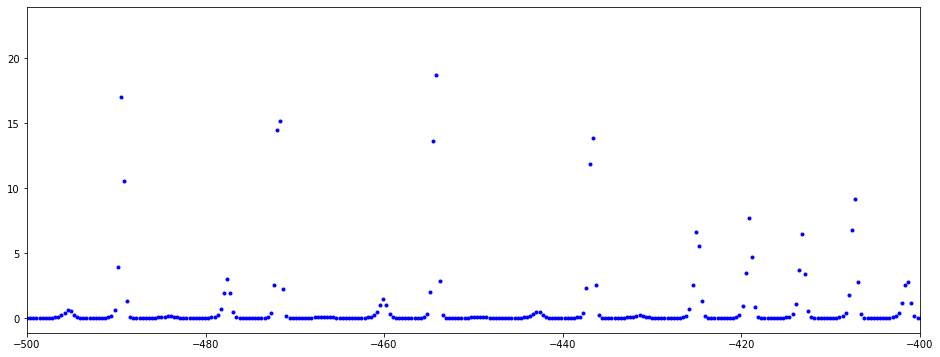

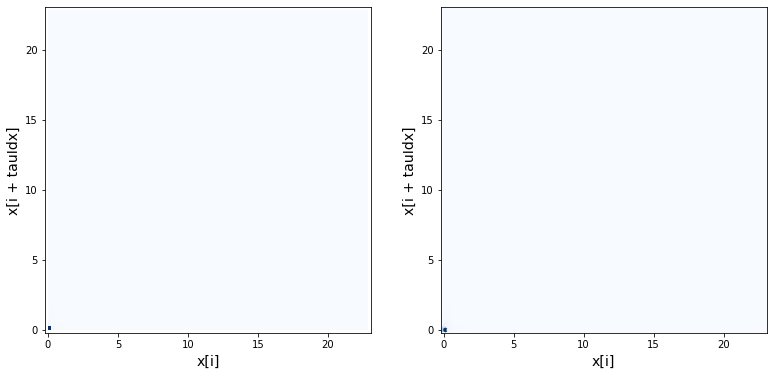

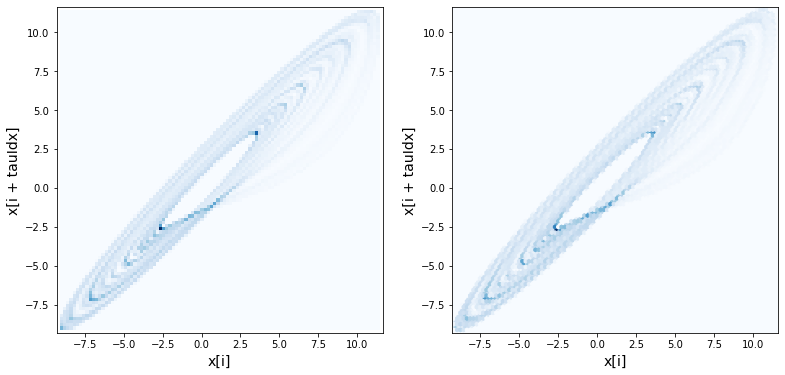

In [88]:
# rossler
#testDelayIdxs = np.array((1,20,50,75,100,109,200,400,500,750,1000))
#testDelayIdxs = np.arange(1,201,10)
#testDelayIdxs = np.arange(110,130,10)
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 35
ax.plot(rossler_t[::delay],rossler_r[::delay,2,],'b.')
ax.set_xlim(-500,-400)
plt.show()

sp.bin2D(timeSeries=rossler_r[:,2], tauIdx = 35) 


sp.bin2D(timeSeries=rossler_r[:,0], tauIdx = 25) 

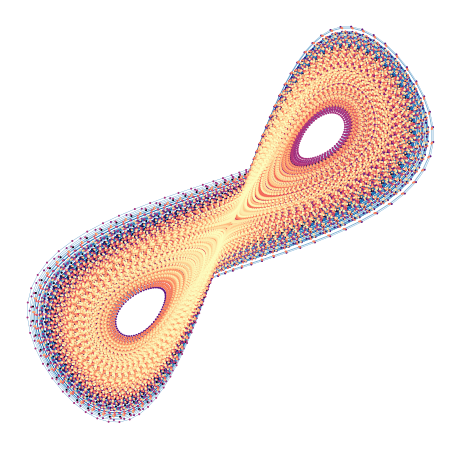

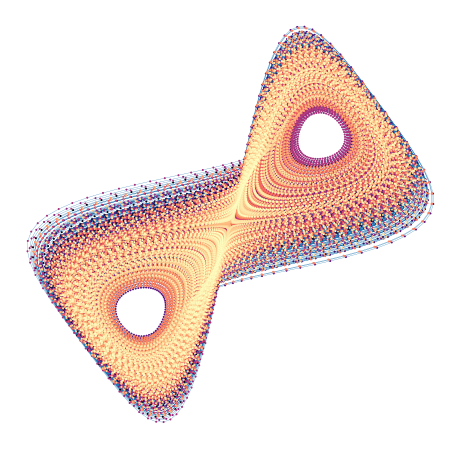

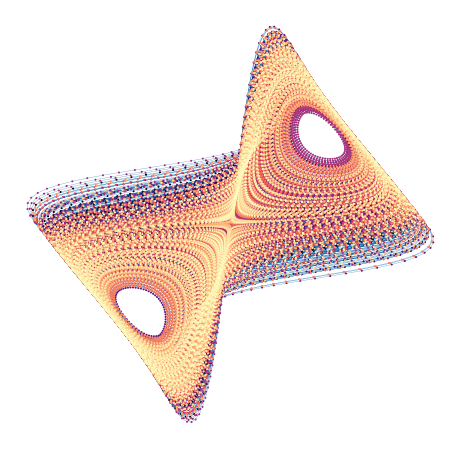

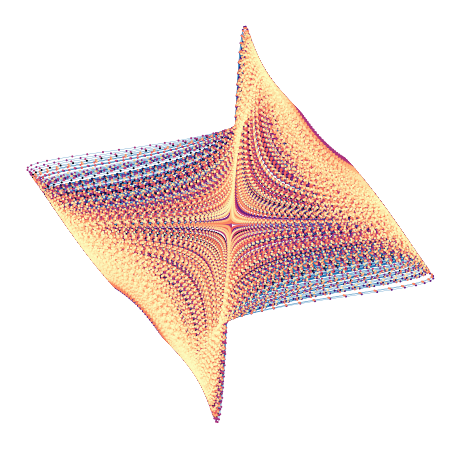

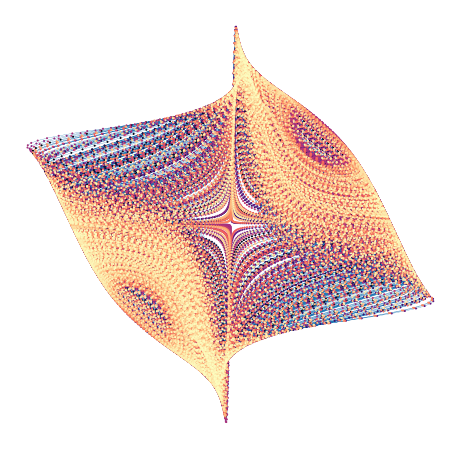

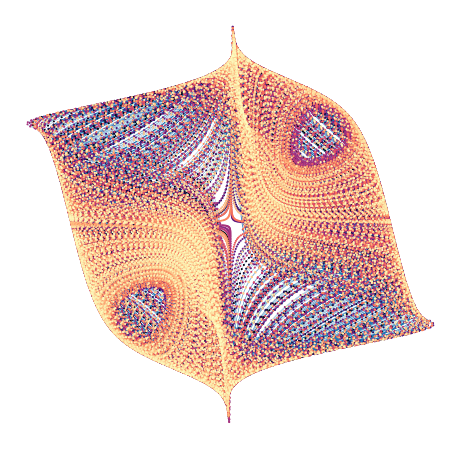

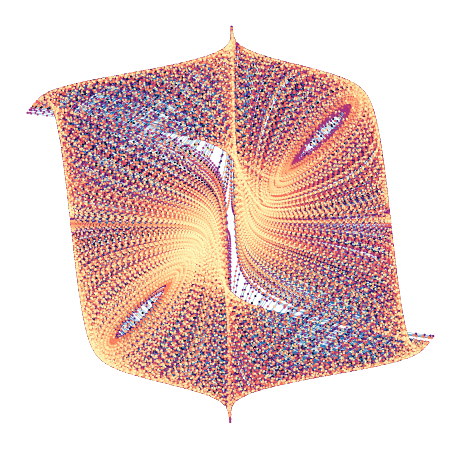

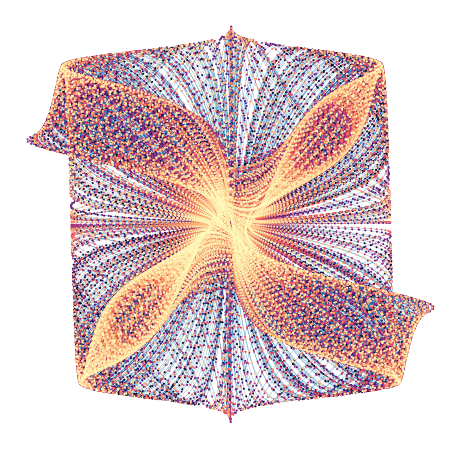

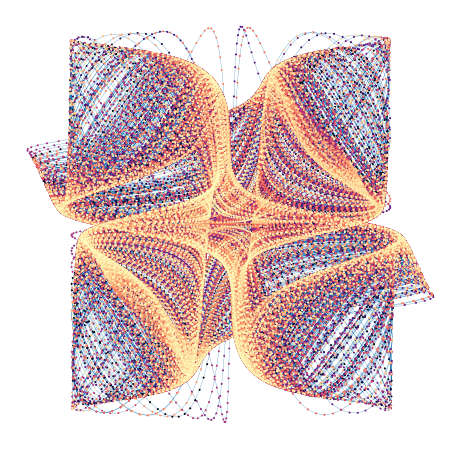

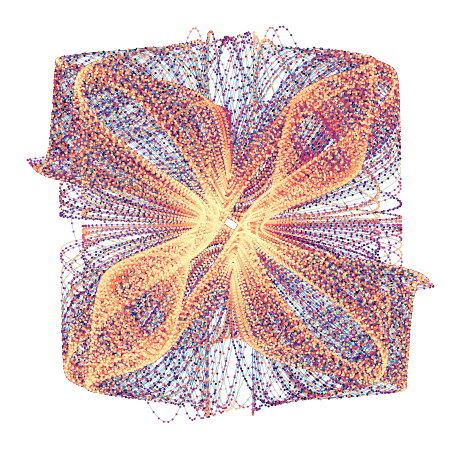

In [211]:
testDelayIdxs = np.array((10,15,20,30,40,50,60,75,100,150))
for i, t in enumerate(testDelayIdxs):
    #sp.bin2D(timeSeries=rossler_r[:,0], tauIdx = i, plotTitle="tauIdx = {0}".format(i))
    x = lorenz_r[:,0][:-t]
    y = lorenz_r[:,0][t:]
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.plot(x,y,ls='-',lw=0.25,marker='None',zorder=1)
    ax.scatter(x,y,c=np.arange(len(x)),cmap='magma',s=1,zorder=2)
    ax.axis("off")
    #plt.savefig("./rossler_x_forposter_tauIdx={0}.pdf".format(t))
    plt.show()
#this is SO COOL
# so just by eye it looks like the first minimum of the mutual information should fall around tau~120 for the Rossler x 
# time series.

In [15]:
MI = np.zeros((500))

start = time.time()
for i in range(500):
    MI[i] = sp.calc_MI(lorenz_r[:-(i+1),0], lorenz_r[(i+1):,0],Xbins=sp.optimal_Nbins(lorenz_r[:-(i+1),0]), Ybins = sp.optimal_Nbins(lorenz_r[(i+1):,0]))
end = time.time()
print((end - start)/500.)

0.01916825199127197


In [16]:
#expectation of first minimum, based on FS86
firstMin = ((193.3*(np.pi/100.)) * 0.23) * 100
print(firstMin)

139.67206778594863


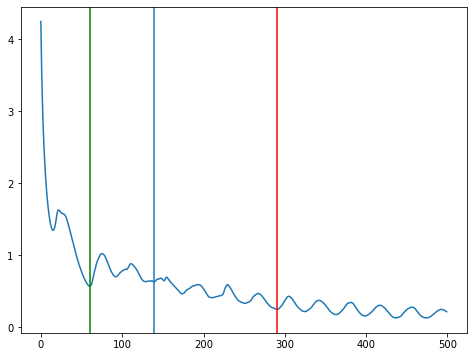

290


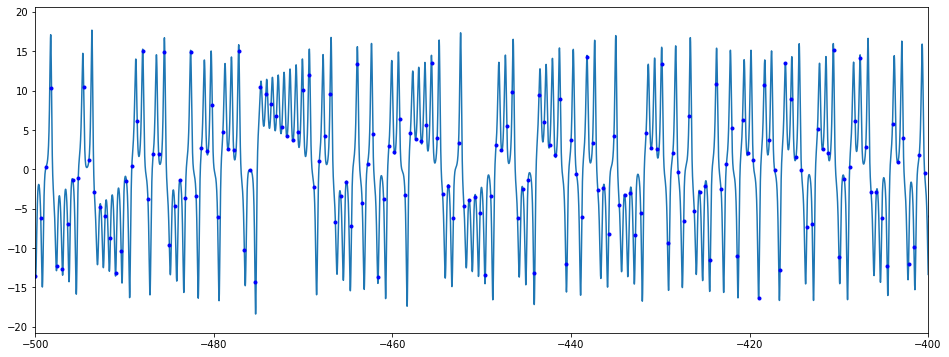

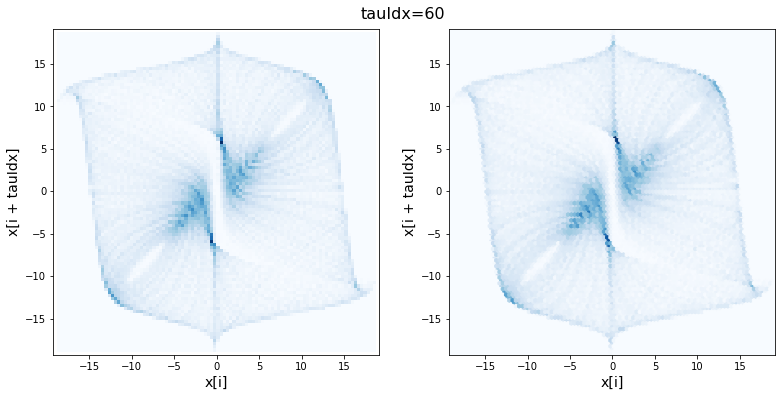

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(MI)
ax.axvline(firstMin)
ax.axvline(np.argmin(MI[0:300]),color='r')
ax.axvline(45+15,color='g')
plt.show()
print(np.argmin(MI[0:300]))

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t,lorenz_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 60 #np.argmin(MI[0:300])
ax.plot(lorenz_t[::delay],lorenz_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()
sp.bin2D(timeSeries=lorenz_r[:,0], tauIdx = 60, plotTitle="tauIdx=60")#plotTitle="tauIdx = {0}".format(np.argmin(MI[0:300])))

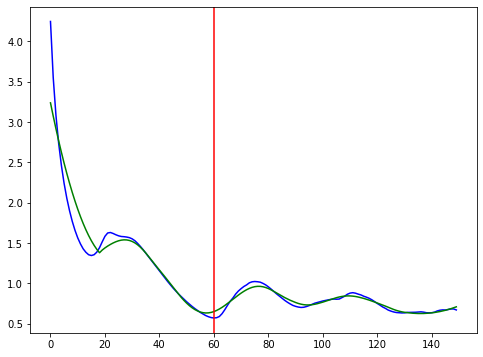

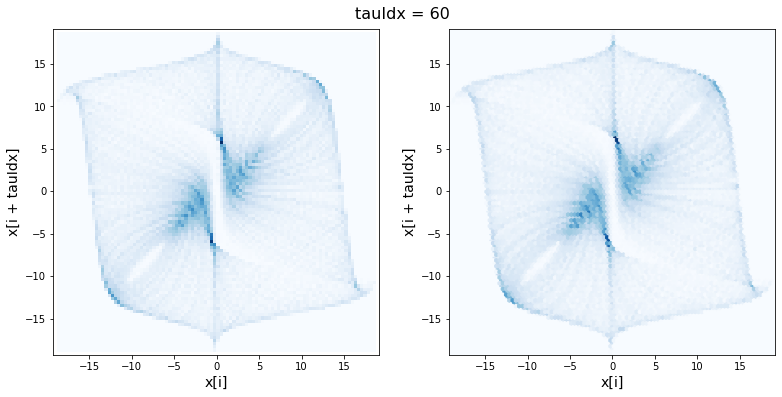

In [15]:
mutInfo, bestTau = sp.FS86(time = lorenz_t, timeSeries = lorenz_r[:,0], plot=True)

# Choose embedding dimension

### Cao 1997

In [3]:
rossler_x_f = ! ls ./corrDimTesting/rossler/rossler_x_P*.npy
rossler_y_f = ! ls ./corrDimTesting/rossler/rossler_y_P*.npy
rossler_z_f = ! ls ./corrDimTesting/rossler/rossler_z_P*.npy
rossler_f = list(rossler_x_f) + list(rossler_y_f) + list(rossler_z_f)

rotated_rossler_x_f = ! ls ./corrDimTesting/rotated_rossler/rotated_rossler_x_P*.npy
rotated_rossler_y_f = ! ls ./corrDimTesting/rotated_rossler/rotated_rossler_y_P*.npy
rotated_rossler_z_f = ! ls ./corrDimTesting/rotated_rossler/rotated_rossler_z_P*.npy
rotated_rossler_f = list(rotated_rossler_x_f) + list(rotated_rossler_y_f) + list(rotated_rossler_z_f)

lorenz_x_f = ! ls ./corrDimTesting/lorenz/lorenz_x_P*.npy
lorenz_y_f = ! ls ./corrDimTesting/lorenz/lorenz_y_P*.npy
lorenz_z_f = ! ls ./corrDimTesting/lorenz/lorenz_z_P*.npy
lorenz_f = list(lorenz_x_f) + list(lorenz_y_f) + list(lorenz_z_f)

print(len(rossler_f))
print(len(rotated_rossler_f))
print(len(lorenz_f))

81
81
81


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


y, Pq=6.3_cad=0.05_Ncyc=5_v2
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=5_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

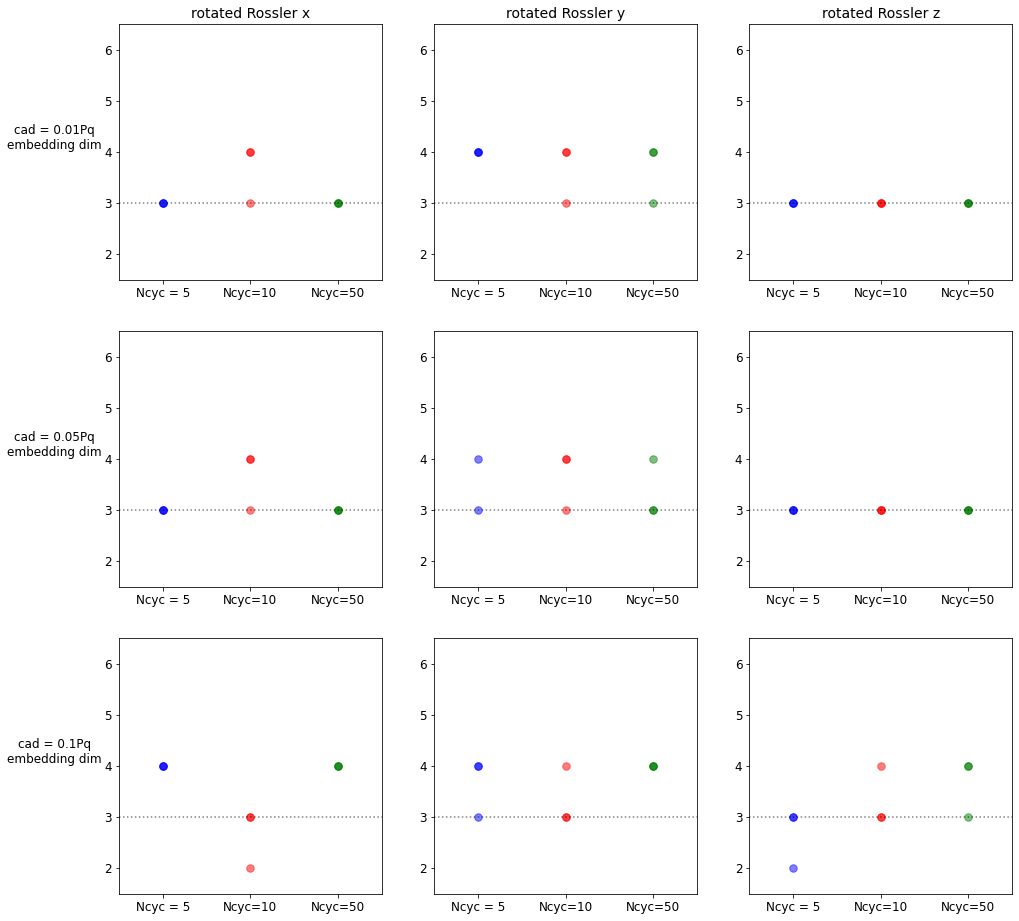

In [21]:

fig, axes = plt.subplots(3,3,figsize=(16,16))

for ts in rotated_rossler_f:
#for ts in ["./corrDimTesting/lorenz_x_Pq=0.8_cad=0.1_Ncyc=5_v0.npy","./corrDimTesting/lorenz_x_Pq=0.8_cad=0.1_Ncyc=5_v1.npy","./corrDimTesting/lorenz_y_Pq=0.7_cad=0.1_Ncyc=10_v0.npy","./corrDimTesting/lorenz_y_Pq=0.7_cad=0.1_Ncyc=10_v1.npy"]:
    #print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    #print(fileName)
    
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]
    #print(timeFileName)

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    
    if "rotated" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]
    #print(varname)
    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    #print(details)
    Pq = float(details.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(details.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(details.split("_v")[1])
    #print(version)
    
    bestTau = sp.FS86(time=time, timeSeries=timeSeries, plot=False)[1]
    E1, E2, sat_m = sp.cao97(timeSeries=timeSeries, tau=bestTau, mMax=8)
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
    ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
    if sat_m is None:
        print("{0}, {1}".format(varname, details))
    else:
        ax.axvline(sat_m, color='k',linestyle=':')
    ax.set_title("{0}, tau = {1}".format(fileName.split(".npy")[0], bestTau))
    ax.set_xlabel('Dimension')
    ax.set_ylabel('E1 & E2')
    ax.legend(loc='best',fontsize=10)
    #plt.show()
    plt.savefig("./plots/cao1997implementation/rotated_rossler/{0}.png".format(fileName.split(".npy")[0]))
    plt.close()
    
    if sat_m is None:
        print(fileName)
        """
        fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
        ax2.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
        ax2.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
        #ax2.axvline(sat_m, color='k',linestyle=':')
        ax2.set_title("{0}, tau = {1}".format(fileName.split(".npy")[0], bestTau))
        ax2.set_xlabel('Dimension')
        ax2.set_ylabel('E1 & E2')
        ax2.legend(loc='best',fontsize=10)
        plt.show()
        """
    
    else:
        if varname=="x":
            firstIdx = 0
        elif varname=="y":
            firstIdx = 1
        elif varname=="z":
            firstIdx = 2

        if cad==0.01:
            zerothIdx = 0
        elif cad==0.05:
            zerothIdx = 1
        elif cad==0.1:
            zerothIdx = 2

        if Ncyc==5:
            xplot = 1
            c = 'b'
        elif Ncyc==10:
            xplot = 2
            c = 'r'
        elif Ncyc==50:
            xplot = 3
            c = 'g'

        axes[zerothIdx, firstIdx].plot(xplot, sat_m, color=c, marker='.',markersize=15,alpha=0.5)

axes[0,0].set_ylabel("cad = 0.01Pq\nembedding dim", rotation=0, labelpad=50, fontsize=12)
axes[1,0].set_ylabel("cad = 0.05Pq\nembedding dim", rotation=0, labelpad=50, fontsize=12)
axes[2,0].set_ylabel("cad = 0.1Pq\nembedding dim", rotation=0, labelpad=50, fontsize=12)

axes[0,0].set_title("rotated Rossler x",fontsize=14)
axes[0,1].set_title("rotated Rossler y",fontsize=14)
axes[0,2].set_title("rotated Rossler z",fontsize=14)

for ax in np.ravel(axes):
    ax.set_xlim(0.5,3.5)
    ax.axhline(3, color='k',linestyle=":", alpha=0.5)
    
    ax.set_ylim(1.5,6.5)
    ax.set_yticks([2,3,4,5,6])
    ax.set_yticklabels(labels=[2,3,4,5,6],fontsize=12)
    
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Ncyc = 5', 'Ncyc=10', 'Ncyc=50'], fontsize=12)
    #ax.set_ylabel("embedding dim")
    
    
plt.savefig("./plots/cao1997implementation/rotated_rossler_m.pdf")

### Gaussian noise

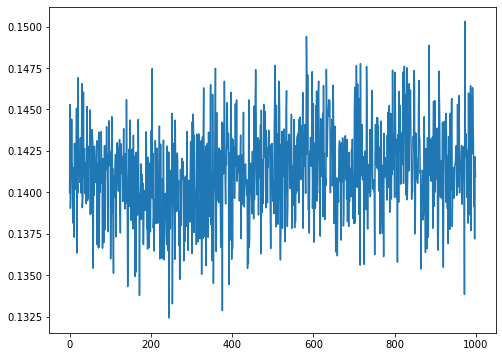

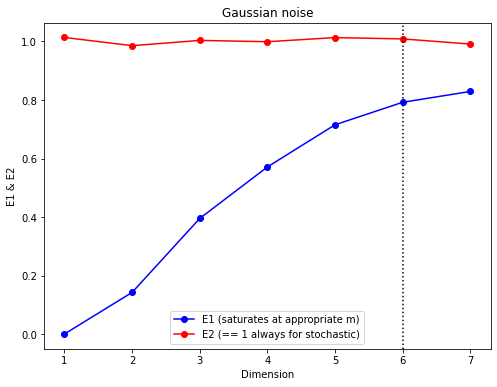

In [15]:
MI = np.zeros(1000)
   
for i,tau in enumerate(np.arange(1000)):
    MI[i] = sp.calc_MI(gaussianNoise[:-(tau+1)], gaussianNoise[(tau+1):],Xbins=sp.optimal_Nbins(gaussianNoise[:-(tau+1)]), Ybins = sp.optimal_Nbins(gaussianNoise[(tau+1):]))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1000), MI)
plt.show()

E1, E2, sat_m = sp.cao97(timeSeries = gaussianNoise[:], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('Gaussian noise')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/gaussian_noise.png")

### Simple periodic

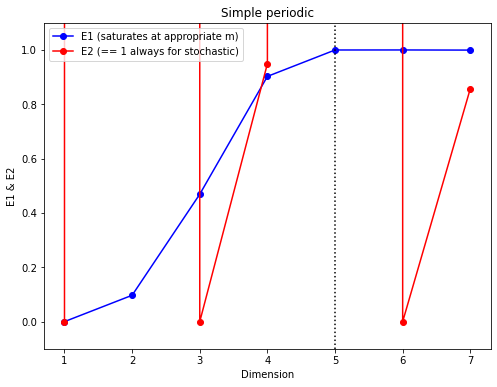

In [20]:
#E1, E2 = sp.cao97(timeSeries = simplePeriodic[:], tau = sp.FS86(time = t, timeSeries = simplePeriodic[:], method="global_min", plot=True)[1], mMax = 8)
E1, E2, sat_m = sp.cao97(timeSeries = simplePeriodic[:], tau = 2060, mMax = 8)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('Simple periodic')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.set_ylim(-0.1,1.1)
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/simple_periodic.png")

### Kovacs & Buchler 1988

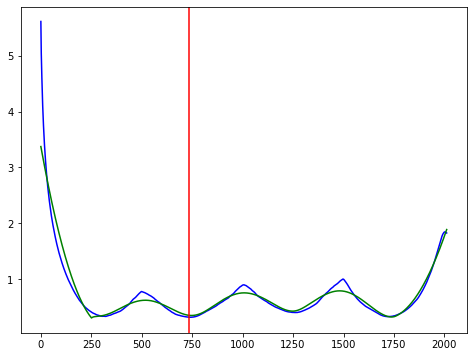

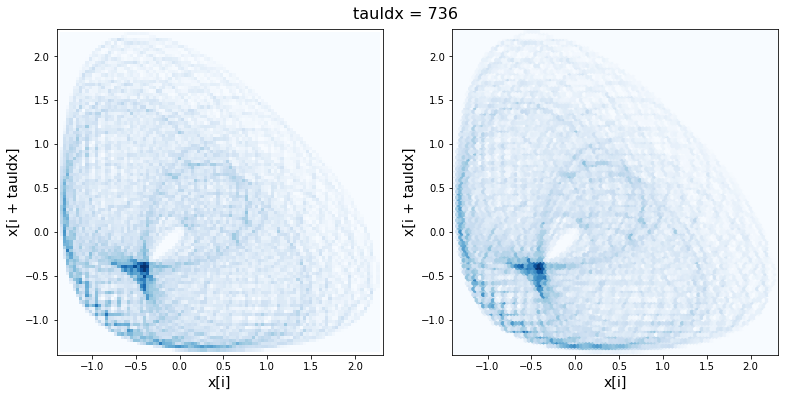

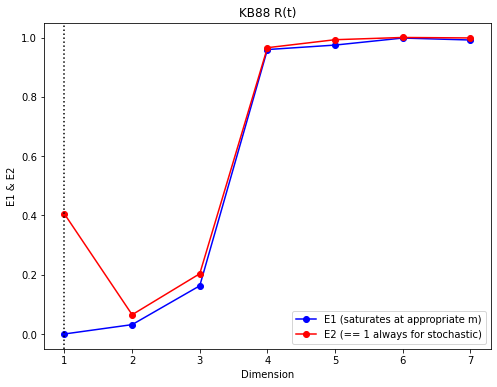

In [9]:
E1, E2, sat_m = sp.cao97(timeSeries = multiPeriodic_r[:], tau = sp.FS86(time=t, timeSeries = multiPeriodic_r[:], plot=True)[1], mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('KB88 R(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_r.png")

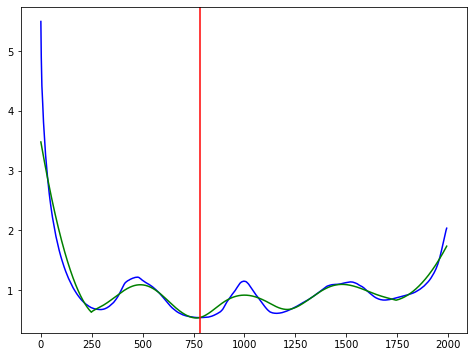

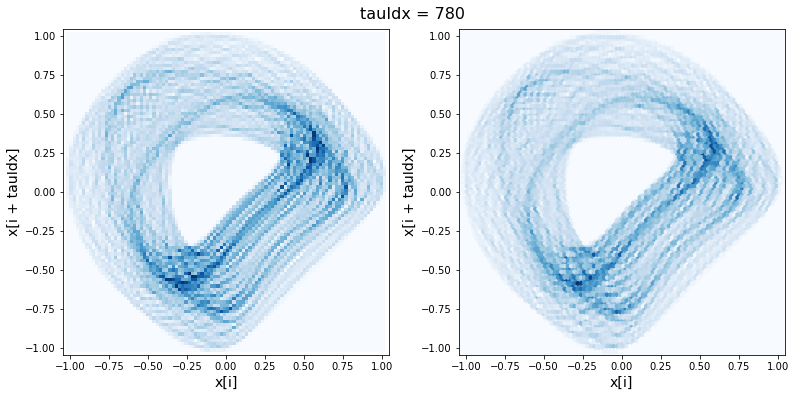

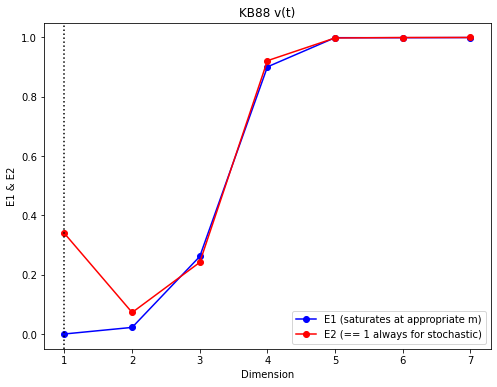

In [10]:
E1, E2, sat_m = sp.cao97(timeSeries = multiPeriodic_v[:], tau = sp.FS86(time=t, timeSeries = multiPeriodic_v[:], plot=True)[1], mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('KB88 v(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_v.png")

### Reproduce Cao 1997 fig 4 (correlated noise)

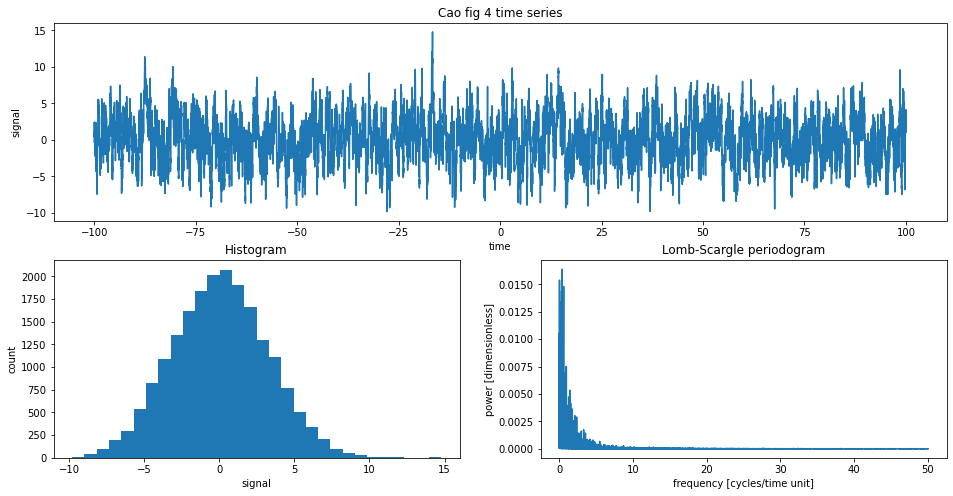

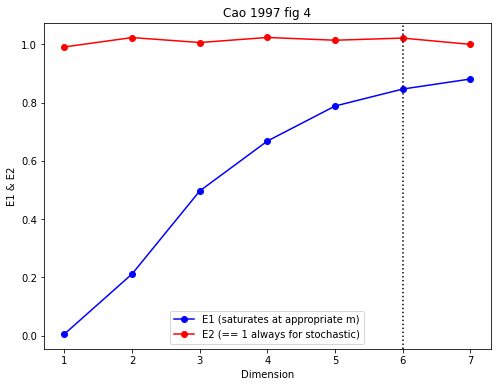

In [11]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise2 = np.random.normal(0.,1.,len(t))

caoFig4 = np.zeros_like(t)
caoFig4[0] = gaussianNoise2[0]
for i in range(1, len(t)):
    caoFig4[i] = caoFig4[i-1]*0.95 + gaussianNoise2[i]
sp.plotTimeSeries(t, caoFig4,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Cao fig 4")

# Cao used tau = 1 for this data, because it's a map rather than a continous diff EQ
E1, E2, sat_m = sp.cao97(timeSeries = caoFig4[:5000], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('Cao 1997 fig 4')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/cao1997fig4.png")

# Calculate correlation integral

### Grassberger & Procaccia 1983

#### They advocate choosing an embedding dimension larger than strictly necessary to reduce error--interesting!

### Start with Kurths & Herzel 1987, actually.

In [3]:
logrArr = np.linspace(-4.,6.,50)
rArr = 2.**logrArr
#np.save("./corrDimTesting/rArr.npy", rArr)


In [4]:
rossler_x_f = ! ls ./corrDimTesting/rossler/rossler_x_P*.npy
rossler_y_f = ! ls ./corrDimTesting/rossler/rossler_y_P*.npy
rossler_z_f = ! ls ./corrDimTesting/rossler/rossler_z_P*.npy
rossler_f = list(rossler_x_f) + list(rossler_y_f) + list(rossler_z_f)

rotated_rossler_x_f = ! ls ./corrDimTesting/rotated_rossler/rotated_rossler_x_P*.npy
rotated_rossler_y_f = ! ls ./corrDimTesting/rotated_rossler/rotated_rossler_y_P*.npy
rotated_rossler_z_f = ! ls ./corrDimTesting/rotated_rossler/rotated_rossler_z_P*.npy
rotated_rossler_f = list(rotated_rossler_x_f) + list(rotated_rossler_y_f) + list(rotated_rossler_z_f)

lorenz_x_f = ! ls ./corrDimTesting/lorenz/lorenz_x_P*.npy
lorenz_y_f = ! ls ./corrDimTesting/lorenz/lorenz_y_P*.npy
lorenz_z_f = ! ls ./corrDimTesting/lorenz/lorenz_z_P*.npy
lorenz_f = list(lorenz_x_f) + list(lorenz_y_f) + list(lorenz_z_f)

print(len(rossler_f))
print(len(rotated_rossler_f))
print(len(lorenz_f))

81
81
81


In [12]:
for ts in rotated_rossler_f:
    #print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    print(fileName)
    
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]
    #print(timeFileName)

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    
    if "rotated" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]
    #print(varname)
    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    #print(details)
    Pq = float(details.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(details.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(details.split("_v")[1])
    #print(version)
    
    bestTau = sp.FS86(time=time, timeSeries=timeSeries, plot=False)[1]
    
    mMax = int(np.floor(len(timeSeries)/bestTau))
    
    E1, E2, sat_m = sp.cao97(timeSeries=timeSeries, tau=bestTau, mMax=mMax)
    
    if sat_m is None:
        print("no saturation")
        mArr = np.arange(2, mMax+1)
    else:
        if sat_m + 1 <= mMax:
            mArr = np.array((sat_m, sat_m + 1))
        elif sat_m <= mMax:
            mArr = np.array((sat_m))
        else:
            mArr = np.arange(2, mMax+1)
    
    print(mArr)
    
    for m in mArr:
        if os.path.exists("./corrDimTesting/rotated_rossler/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m)):
            pass
        else:
            #print("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m))
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=timeSeries, tau = bestTau, m = m)
            np.save("./corrDimTesting/rotated_rossler/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m),C0_)
            np.save("./corrDimTesting/rotated_rossler/cArrs/{0}_tau={1}_m={2}_C1.npy".format(fileName.split(".npy")[0],bestTau,m),C1_)
            np.save("./corrDimTesting/rotated_rossler/cArrs/{0}_tau={1}_m={2}_C2.npy".format(fileName.split(".npy")[0],bestTau,m),C2_)
            np.save("./corrDimTesting/rotated_rossler/cArrs/{0}_tau={1}_m={2}_nArr.npy".format(fileName.split(".npy")[0],bestTau,m),nArr_)
    

rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=10_v0.npy
[4 5]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=10_v1.npy
[4 5]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=5_v0.npy
[3 4]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=5_v1.npy
[3 4]
rotated_rossler_x_Pq=6.3_cad=0.01_Ncyc=5_v2.npy
[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=5_v0.npy
[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_x_Pq=6.3_cad=0.05_Ncyc=5_v2.npy
[3 4]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[2 3]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_x_Pq=6.3_cad=0.1_Ncyc=5_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=10_v0.npy
[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=10_v1.npy
[3 4]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=10_v2.npy
[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=5_v0.npy
[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=5_v1.npy
[4 5]
rotated_rossler_y_Pq=6.3_cad=0.01_Ncyc=5_v2.npy
[4 5]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_y_Pq=6.3_cad=0.05_Ncyc=5_v2.npy
no saturation
[2 3 4 5 6]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[4 5]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_y_Pq=6.3_cad=0.1_Ncyc=5_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=10_v1.npy
[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=10_v2.npy
[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=5_v0.npy
[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=5_v1.npy
[3 4]
rotated_rossler_z_Pq=6.3_cad=0.01_Ncyc=5_v2.npy
[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.05_Ncyc=5_v2.npy
[3 4]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[3 4]
rotated_rossler_z_Pq=6.3_cad=0.1_Ncyc=5_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[2 3]


## Plot results of multiple runs

In [165]:
rArr = np.load("./corrDimTesting/rArr.npy")

In [166]:
rossler_x_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_x_P*C0.npy
rossler_y_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_y_P*C0.npy
rossler_z_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_z_P*C0.npy
rossler_C0 = list(rossler_x_C0) + list(rossler_y_C0) + list(rossler_z_C0)

rotated_rossler_x_C0 = ! ls ./corrDimTesting/rotated_rossler/cArrs/rotated_rossler_x_P*C0.npy
rotated_rossler_y_C0 = ! ls ./corrDimTesting/rotated_rossler/cArrs/rotated_rossler_y_P*C0.npy
rotated_rossler_z_C0 = ! ls ./corrDimTesting/rotated_rossler/cArrs/rotated_rossler_z_P*C0.npy
rotated_rossler_C0 = list(rotated_rossler_x_C0) + list(rotated_rossler_y_C0) + list(rotated_rossler_z_C0)

lorenz_x_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_x_P*C0.npy
lorenz_y_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_y_P*C0.npy
lorenz_z_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_z_P*C0.npy
lorenz_C0 = list(lorenz_x_C0) + list(lorenz_y_C0) + list(lorenz_z_C0)

print(len(rossler_C0))
print(len(rotated_rossler_C0))
print(len(lorenz_C0))

160
166
150


# Trying new way of calculating dimension---instead of fitting a single power-law slope to C2 vs r, how about fitting an individual power law slope to each n_i(r) vs r, then looking at the distribution of resulting slopes?

In [36]:
#import warnings
#warnings.filterwarnings("ignore")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt
/Users/Emily/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in sqrt
/Users/Emily/anaconda3/lib/python3.7/site-

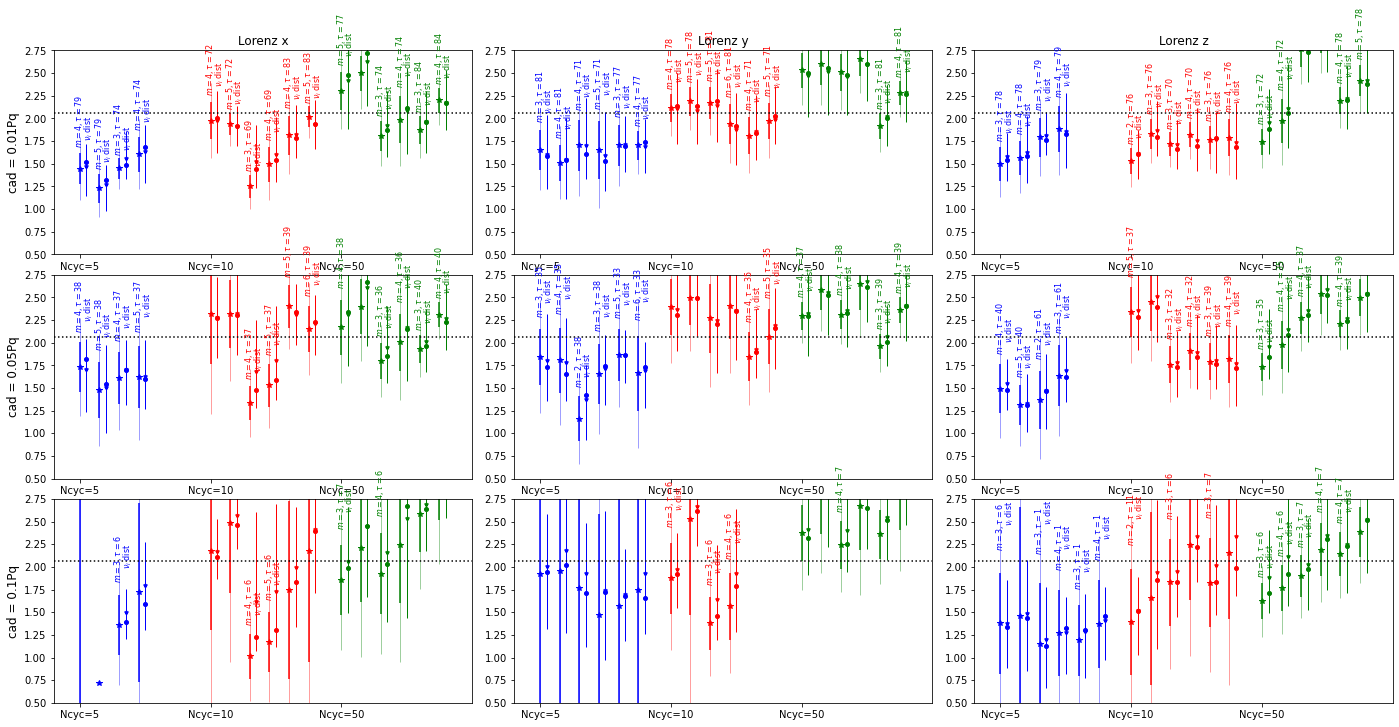

In [45]:
lorenz_truth = 2.06 # e.g. McGuinness 1983
rossler_truth = 2.01 # Sprott & Rowland 2000

fig, axes = plt.subplots(3,3,figsize=(24,12))
counters = np.zeros((3,3,3))
for f in lorenz_C0:
    #print(f)
    #C0 = np.load(f)
    #C1 = np.load("./corrDimTesting/" + fileName[:-2] + "C1.npy")
    C2 = np.load(f[:-6] + "C2.npy")
    nArr = np.load(f[:-6] + "nArr.npy")
    #print(np.shape(nArr))
    
    Pq = float(f.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(f.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(f.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(f.split("_v")[1].split("_")[0])
    #print(version)
    tau = int(f.split("tau=")[1].split("_")[0])
    #print(tau)
    m = int(f.split("m=")[1].split("_")[0])
    #print(m)
    
    N = np.shape(nArr)[0]
    medians = np.percentile(nArr, 50, axis=0)
        
    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    anyNans = np.array(anyNans)
    nansIdxs = np.arange(len(rArr))[anyNans]
    lastGood = nansIdxs[0]
    
    params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
    
    params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)
    #print(np.shape(params_dist))
    #print(np.shape(params_dist[:,0]))
    
    """
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    for i in range(len(params_dist)):
        #ax.plot(rArr, nArr[i], 'k-', marker='None', lw=1, alpha=0.1)
        #ax.plot(rArr[firstGood:lastGood], nArr[i][firstGood:lastGood], 'k-', marker='None', lw=1, alpha=0.1)
        ax.plot(rArr[firstGood:lastGood], (10**params_dist[i][1])*rArr[firstGood:lastGood]**params_dist[i][0], 'r-', marker='None', lw=1, alpha=0.1)
    #ax.plot(rArr, C2, 'ko', ls="None")
    ax.plot(rArr[firstGood:lastGood], C2[firstGood:lastGood], 'ko', ls="None")
    print(params_C2[1])
    ax.plot(rArr[firstGood:lastGood], (10**params_C2[1])*rArr[firstGood:lastGood]**params_C2[0], 'b-', marker='None', lw=2, alpha=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.show()
    """
    
    if cad==0.01:
        idx_0 = 0
    elif cad==0.05:
        idx_0 = 1
    elif cad==0.1:
        idx_0 = 2

    if "_x_" in f:
        idx_1 = 0
    elif "_y_" in f:
        idx_1 = 1
    elif "_z_" in f:
        idx_1 = 2

    if Ncyc==5:
        start_x = 1
        color = 'b'
        idx_2 = 0
    elif Ncyc==10:
        start_x = 2
        color = 'r'
        idx_2 = 1
    elif Ncyc==50:
        start_x = 3
        color = 'g'
        idx_2 = 2

    #
    #for i in range(len(params_dist)):
    #    axes[idx_0,idx_1].plot(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_dist[i][0],marker='o', color='k',ms=3,alpha=0.05,zorder=i)
    
    axes[idx_0,idx_1].errorbar(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color=color, elinewidth=1.5,alpha=1.,zorder=2)
    axes[idx_0,idx_1].errorbar(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0], 2*np.sqrt(params_unc_C2[0,0]), marker='None', color=color, elinewidth=0.75,alpha=0.5,zorder=1)
    
    p16 = np.percentile(params_dist[:,0],16)
    p50 = np.percentile(params_dist[:,0],50)
    v_mean = np.mean(params_dist[:,0])
    p84 = np.percentile(params_dist[:,0],84)
    
    axes[idx_0,idx_1].plot(start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2],p50, marker='o',ms=4,color=color,lw=1.,alpha=1,zorder=2)
    axes[idx_0,idx_1].plot(start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2],v_mean, marker='*',ms=4,color=color,lw=1.,alpha=1,zorder=2)
    
    axes[idx_0,idx_1].vlines(x=start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2], ymin=p16, ymax=p84, color=color,lw=1.,alpha=1,zorder=1)
    
    
    axes[idx_0,idx_1].annotate(r"$m={0},\tau={1}$".format(m,tau), (start_x -0.05 + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0]+1.5*np.sqrt(params_unc_C2[0,0])),rotation=90,color=color,fontsize=8,zorder=3)   
    axes[idx_0,idx_1].annotate(r"$\nu_i$ dist".format(m,tau), (start_x + 0.02 + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0]+2*np.sqrt(params_unc_C2[0,0])),rotation=90,color=color,fontsize=8,zorder=3)   

    counters[idx_0,idx_1,idx_2] += 1


axes[0,0].set_ylabel("cad = 0.01Pq", fontsize=12)
axes[1,0].set_ylabel("cad = 0.05Pq", fontsize=12)
axes[2,0].set_ylabel("cad = 0.1Pq", fontsize=12)


axes[0,0].set_title("Lorenz x", fontsize=12)
axes[0,1].set_title("Lorenz y", fontsize=12)
axes[0,2].set_title("Lorenz z", fontsize=12)

for ax in np.ravel(axes):
    ax.axhline(y = lorenz_truth,color='k',linestyle=":",lw=1.5)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["Ncyc=5","Ncyc=10","Ncyc=50"])
    ax.set_xlim(0.8,4.)
    
for ax in axes[:,0]:
    ax.set_ylim(0.5,2.75)
for ax in axes[:,1]:
    ax.set_ylim(0.5,2.75)
for ax in axes[:,2]:
    ax.set_ylim(0.5,2.75)

plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz_recoveredPowerLawSlope_severalTrials.pdf")


# Colormap delay diagrams by recovered dimension

In [209]:
for f in lorenz_C0:
    #print(f)
    #C0 = np.load(f)
    #C1 = np.load("./corrDimTesting/" + fileName[:-2] + "C1.npy")
    C2 = np.load(f[:-6] + "C2.npy")
    nArr = np.load(f[:-6] + "nArr.npy")
    #print(np.shape(nArr))
    
    tsName = "/".join(f.split("/")[0:3]) +"/"+ f.split("/")[-1].split("_tau")[0] + ".npy"
    ts = np.load(tsName)
    
    Pq = float(f.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(f.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(f.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(f.split("_v")[1].split("_")[0])
    #print(version)
    tau = int(f.split("tau=")[1].split("_")[0])
    #print(tau)
    m = int(f.split("m=")[1].split("_")[0])
    #print(m)
    
    if "rotated" in f:
        varname = " ".join(f.split("/")[-1].split("_")[0:3])
    else:
        varname = " ".join(f.split("/")[-1].split("_")[0:2])
    
    delayMat = sp.delayMatrix(ts, tau, m)
    #print(np.shape(delayMat))
    
    N = np.shape(nArr)[0]
    medians = np.percentile(nArr, 50, axis=0)
        
    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    anyNans = np.array(anyNans)
    nansIdxs = np.arange(len(rArr))[anyNans]
    lastGood = nansIdxs[0]
    
    params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
    
    params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)
          
    #print(np.shape(params_dist))
    #print(np.shape(params_dist[:,0]))
    
    fig, axes = plt.subplots(m-1,1,figsize=(6, 6*(m-1)))
    axes = np.atleast_1d(axes)
    for j in range(1,m):
        axes[m-1-j].plot(delayMat[:,0],delayMat[:,j],linestyle='-',color='k',lw=0.25,marker="None",zorder=1)
        im = axes[m-1-j].scatter(delayMat[:,0],delayMat[:,j],c=params_dist[:,0],s=10,cmap="plasma",linewidths=0,alpha=0.9,zorder=2)
        
        divider = make_axes_locatable(axes[m-1-j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
        
        axes[m-1-j].set_ylabel(r"{0}$_i + {1}\tau$".format(varname,j),fontsize=14)
    
    axes[m-2].set_xlabel(r"{0}$_i$".format(varname),fontsize=14)
    plt.subplots_adjust(hspace=0.1)
    #plt.show()
    plt.savefig("./plots/gp1983implementation/lorenz/{0}.png".format(f.split("/")[-1][:-7]),dpi=300)
    plt.close()


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarnin

## Old

In [ ]:
"""
combos = [(15,3),(60,3),(15,4),(60,4)]
C0_1000 = [C0_1000_t15_m3, C0_1000_t60_m3, C0_1000_t15_m4, C0_1000_t60_m4]
C1_1000 = [C1_1000_t15_m3, C1_1000_t60_m3, C1_1000_t15_m4, C1_1000_t60_m4]
C2_1000 = [C2_1000_t15_m3, C2_1000_t60_m3, C2_1000_t15_m4, C2_1000_t60_m4]
n_1000 = [nArr_1000_t15_m3, nArr_1000_t60_m3, nArr_1000_t15_m4, nArr_1000_t60_m4]

C0_5000 = [C0_5000_t15_m3, C0_5000_t60_m3, C0_5000_t15_m4, C0_5000_t60_m4]
C1_5000 = [C1_5000_t15_m3, C1_5000_t60_m3, C1_5000_t15_m4, C1_5000_t60_m4]
C2_5000 = [C2_5000_t15_m3, C2_5000_t60_m3, C2_5000_t15_m4, C2_5000_t60_m4]
n_5000 = [nArr_5000_t15_m3, nArr_5000_t60_m3, nArr_5000_t15_m4, nArr_5000_t60_m4]

C0_10000 = [C0_10000_t15_m3, C0_10000_t60_m3, C0_10000_t15_m4, C0_10000_t60_m4]
C1_10000 = [C1_10000_t15_m3, C1_10000_t60_m3, C1_10000_t15_m4, C1_10000_t60_m4]
C2_10000 = [C2_10000_t15_m3, C2_10000_t60_m3, C2_10000_t15_m4, C2_10000_t60_m4]
n_10000 = [nArr_10000_t15_m3, nArr_10000_t60_m3, nArr_10000_t15_m4, nArr_10000_t60_m4]

C0_20000 = [C0_20000_t15_m3, C0_20000_t60_m3, C0_20000_t15_m4, C0_20000_t60_m4]
C1_20000 = [C1_20000_t15_m3, C1_20000_t60_m3, C1_20000_t15_m4, C1_20000_t60_m4]
C2_20000 = [C2_20000_t15_m3, C2_20000_t60_m3, C2_20000_t15_m4, C2_20000_t60_m4]
n_20000 = [nArr_20000_t15_m3, nArr_20000_t60_m3, nArr_20000_t15_m4, nArr_20000_t60_m4]

# vertical offsets for the different-length time series
vOffset = [10**7, 10**5, 10**3, 10**1]

# adjustments to vertical offsets for the different choices of tau and m
bOffset = [10**-2.45,10**-3,10**-2.75,10**-3.25]
Narr = [(970,4970,9970,19970),(880,4880,9880,19880),(955,4995,9955,19955),(820,4820,9820,19820)]


for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    
    p84_1000 = np.percentile(n_1000[i], 84, axis=0)
    p50_1000 = np.percentile(n_1000[i], 50, axis=0)
    p16_1000 = np.percentile(n_1000[i], 16, axis=0)
    
    p84_5000 = np.percentile(n_5000[i], 84, axis=0)
    p50_5000 = np.percentile(n_5000[i], 50, axis=0)
    p16_5000 = np.percentile(n_5000[i], 16, axis=0)
    
    p84_10000 = np.percentile(n_10000[i], 84, axis=0)
    p50_10000 = np.percentile(n_10000[i], 50, axis=0)
    p16_10000 = np.percentile(n_10000[i], 16, axis=0)
    
    p84_20000 = np.percentile(n_20000[i], 84, axis=0)
    p50_20000 = np.percentile(n_20000[i], 50, axis=0)
    p16_20000 = np.percentile(n_20000[i], 16, axis=0)
    
    fig, axes = plt.subplots(3,1,figsize=(12,24))
    
    axes[0].plot(rArr,C0_1000[i] * vOffset[0],color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")    
    axes[0].plot(rArr,C1_1000[i] * vOffset[0],color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[0].plot(rArr,C2_1000[i] * vOffset[0],color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[0].vlines(x=rArr, ymin=p16_1000 * vOffset[0], ymax=p84_1000 * vOffset[0], color='b',lw=1)
    
    axes[0].plot(rArr,C0_5000[i] * vOffset[1],color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[0].plot(rArr,C1_5000[i] * vOffset[1],color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[0].plot(rArr,C2_5000[i] * vOffset[1],color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[0].vlines(x=rArr, ymin=p16_5000 * vOffset[1], ymax=p84_5000 * vOffset[1], color='r',lw=1)
    
    axes[0].plot(rArr,C0_10000[i]* vOffset[2],color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[0].plot(rArr,C1_10000[i]* vOffset[2],color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[0].plot(rArr,C2_10000[i]* vOffset[2],color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[0].vlines(x=rArr, ymin=p16_10000 * vOffset[2], ymax=p84_10000 * vOffset[2], color='g',lw=1)
    
    axes[0].plot(rArr,C0_20000[i]* vOffset[3],color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[0].plot(rArr,C1_20000[i]* vOffset[3],color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[0].plot(rArr,C2_20000[i]* vOffset[3],color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[0].vlines(x=rArr, ymin=p16_20000 * vOffset[3], ymax=p84_20000 * vOffset[3], color='m',lw=1)
    
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[0],'b-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[1],'r-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[2],'g-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[3],'m-',lw=1)

    axes[0].text(10.,vOffset[0]*0.5,r"$r^{2.06}$",color='b',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[1]*0.5,r"$r^{2.06}$",color='r',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[2]*0.5,r"$r^{2.06}$",color='g',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[3]*0.5,r"$r^{2.06}$",color='m',fontsize=14,rotation=20)
    
    axes[0].set_ylabel(r"$\log_{10}[C(r)]$", fontsize=16)
    axes[0].set_title(r"Lorenz $x$ $C_2(r)$ tau={0}, m={1}; cf GP83 fig. 1".format(t,m),fontsize=16)
    axes[0].set_yscale("log")
    axes[0].set_ylim(1.e-6,1.e8)
    axes[0].set_yticklabels([-8,-6,-4,-2,0,2,4,6,8])
    
    # residuals compared to power law
    axes[1].plot(rArr,np.log10(C0_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[1].plot(rArr,np.log10(C1_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[1].plot(rArr,np.log10(C2_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='b',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[1].plot(rArr,np.log10(C1_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[1].plot(rArr,np.log10(C2_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='r',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[1].plot(rArr,np.log10(C1_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[1].plot(rArr,np.log10(C2_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='g',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[1].plot(rArr,np.log10(C1_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[1].plot(rArr,np.log10(C2_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='m',lw=1.,alpha=1)
    
    axes[1].axhline(0,color='k',ls=':')
    axes[1].set_title(r"residuals compared to $r^{2.06}$ power law ($\log_{10}$ space)",fontsize=16)
    
    # residuals compared to 20000 data points
    axes[2].plot(rArr,np.log10(C0_1000[i]) - np.log10(C0_20000[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[2].plot(rArr,np.log10(C1_1000[i]) - np.log10(C1_20000[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[2].plot(rArr,np.log10(C2_1000[i]) - np.log10(C2_20000[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(C1_20000[i]), ymax=np.log10(p84_1000)-np.log10(C1_20000[i]), color='b',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_5000[i]) - np.log10(C0_20000[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[2].plot(rArr,np.log10(C1_5000[i]) - np.log10(C1_20000[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[2].plot(rArr,np.log10(C2_5000[i]) - np.log10(C2_20000[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(C1_20000[i]), ymax=np.log10(p84_5000)-np.log10(C1_20000[i]), color='r',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_10000[i]) - np.log10(C0_20000[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[2].plot(rArr,np.log10(C1_10000[i]) - np.log10(C1_20000[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[2].plot(rArr,np.log10(C2_10000[i]) - np.log10(C2_20000[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(C1_20000[i]), ymax=np.log10(p84_10000)-np.log10(C1_20000[i]), color='g',lw=1.,alpha=1)
    
    axes[2].axhline(0,color='k',ls=':')
    axes[2].set_title(r"residuals compared to 20000 data points ($\log_{10}$ space)",fontsize=16)
    

    for ax in axes:
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xlabel(r"$\log_{10}[r]$", fontsize=16)
        ax.set_xscale("log")
        ax.set_xlim(5.e-2,1.e2)
        ax.set_xticklabels([-3,-2,-1,0,1,2])
        ax.legend(loc="lower right",frameon=True,framealpha=1.0, edgecolor='None')
    
    #plt.show()
    plt.savefig("./plots/gp1983implementation/lorenz_x_timeSeriesLength_tau={0}_m={1}.pdf".format(t,m))
"""

In [ ]:
'''
fig, axes = plt.subplots(4,1,figsize=(4,10))#plt.subplots(4,3,figsize=(8,8))

for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    """
    params_1000_C0, params_unc_1000_C0 = sp.fitLinearRegime(rArr, n_1000[i], C0_1000[i])
    params_5000_C0, params_unc_5000_C0 = sp.fitLinearRegime(rArr, n_5000[i], C0_5000[i])
    params_10000_C0, params_unc_10000_C0 = sp.fitLinearRegime(rArr, n_10000[i], C0_10000[i])
    params_20000_C0, params_unc_20000_C0 = sp.fitLinearRegime(rArr, n_20000[i], C0_20000[i])
    
    params_1000_C1, params_unc_1000_C1 = sp.fitLinearRegime(rArr, n_1000[i], C1_1000[i])
    params_5000_C1, params_unc_5000_C1 = sp.fitLinearRegime(rArr, n_5000[i], C1_5000[i])
    params_10000_C1, params_unc_10000_C1 = sp.fitLinearRegime(rArr, n_10000[i], C1_10000[i])
    params_20000_C1, params_unc_20000_C1 = sp.fitLinearRegime(rArr, n_20000[i], C1_20000[i])
    """
    params_1000_C2, params_unc_1000_C2 = sp.fitLinearRegime(rArr, n_1000[i], C2_1000[i])
    params_5000_C2, params_unc_5000_C2 = sp.fitLinearRegime(rArr, n_5000[i], C2_5000[i])
    params_10000_C2, params_unc_10000_C2 = sp.fitLinearRegime(rArr, n_10000[i], C2_10000[i])
    params_20000_C2, params_unc_20000_C2 = sp.fitLinearRegime(rArr, n_20000[i], C2_20000[i])
    """
    axes[i,0].axhline(2.06,color='k',linestyle=":")
    axes[i,0].errorbar(1, params_1000_C0[0], np.sqrt(params_unc_1000_C0[0,0]), marker='.', color='b', elinewidth=1,label='1000 points')
    axes[i,0].errorbar(2, params_5000_C0[0], np.sqrt(params_unc_5000_C0[0,0]), marker='.', color='r', elinewidth=1, label='5000 points')
    axes[i,0].errorbar(3, params_10000_C0[0], np.sqrt(params_unc_10000_C0[0,0]), marker='.', color='g', elinewidth=1, label='10000 points')
    axes[i,0].errorbar(4, params_20000_C0[0], np.sqrt(params_unc_20000_C0[0,0]), marker='.', color='m', elinewidth=1, label='20000 points')
    axes[i,0].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i,0].set_xticks([])
    axes[i,0].set_ylim(1.25,3)
    
    axes[i,1].axhline(2.06,color='k',linestyle=":")
    axes[i,1].errorbar(1, params_1000_C1[0], np.sqrt(params_unc_1000_C1[0,0]), marker='o', color='b', elinewidth=1,label='1000 points')
    axes[i,1].errorbar(2, params_5000_C1[0], np.sqrt(params_unc_5000_C1[0,0]), marker='o', color='r', elinewidth=1, label='5000 points')
    axes[i,1].errorbar(3, params_10000_C1[0], np.sqrt(params_unc_10000_C1[0,0]), marker='o', color='g', elinewidth=1, label='10000 points')
    axes[i,1].errorbar(4, params_20000_C1[0], np.sqrt(params_unc_20000_C1[0,0]), marker='o', color='m', elinewidth=1, label='20000 points')
    axes[i,1].set_xticks([])
    axes[i,1].set_ylim(1.25,3)
    """
    axes[i].axhline(2.06,color='k',linestyle=":")
    axes[i].errorbar(1, params_1000_C2[0], np.sqrt(params_unc_1000_C2[0,0]), marker='*', color='b', elinewidth=1,label='1000 points')
    axes[i].errorbar(2, params_5000_C2[0], np.sqrt(params_unc_5000_C2[0,0]), marker='*', color='r', elinewidth=1, label='5000 points')
    axes[i].errorbar(3, params_10000_C2[0], np.sqrt(params_unc_10000_C2[0,0]), marker='*', color='g', elinewidth=1, label='10000 points')
    axes[i].errorbar(4, params_20000_C2[0], np.sqrt(params_unc_20000_C2[0,0]), marker='*', color='m', elinewidth=1, label='20000 points')
    axes[i].set_xticks([])
    axes[i].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i].set_ylim(1.25,3)
    
axes[0].legend(fontsize=8,loc='upper right', frameon=False)

#axes[0,0].set_title("C0")
#axes[0,1].set_title("C1")
axes[0].set_title("C2")
plt.subplots_adjust(hspace=0.1,wspace=0.4)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz_x_recoveredPowerLawSlope.pdf")
'''

In [90]:
x = np.load("./corrDimTesting/rossler/rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v0.npy")
tx = np.load("./corrDimTesting/rossler/rossler_x_t_Pq=6.3_cad=0.01_Ncyc=50_v0.npy")
z = np.load("./corrDimTesting/rossler/rossler_z_Pq=5.9_cad=0.01_Ncyc=50_v0.npy")
tz = np.load("./corrDimTesting/rossler/rossler_z_t_Pq=5.9_cad=0.01_Ncyc=50_v0.npy")

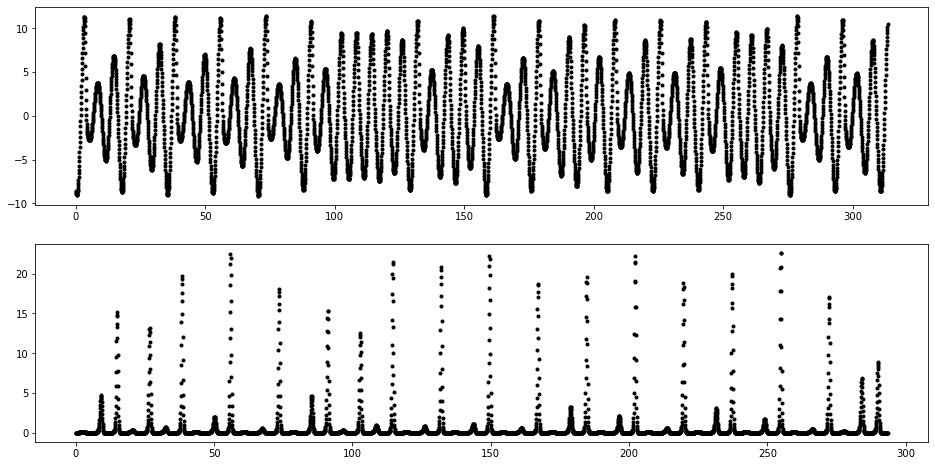

In [91]:
fig, axes = plt.subplots(2,1,figsize=(16,8))

axes[0].plot(tx,x,'k.')
axes[1].plot(tz,z,'k.')
plt.show()

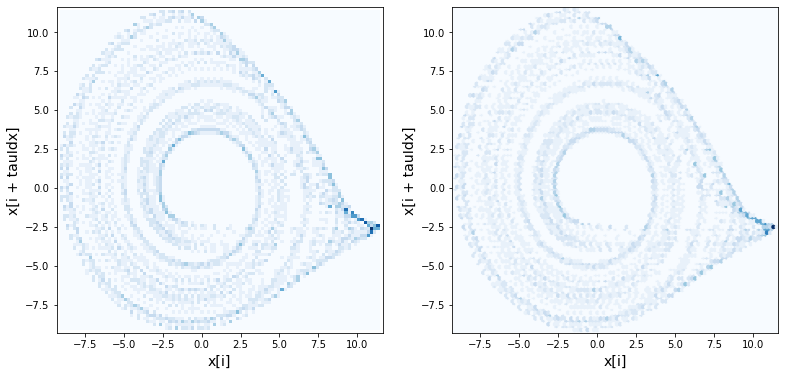

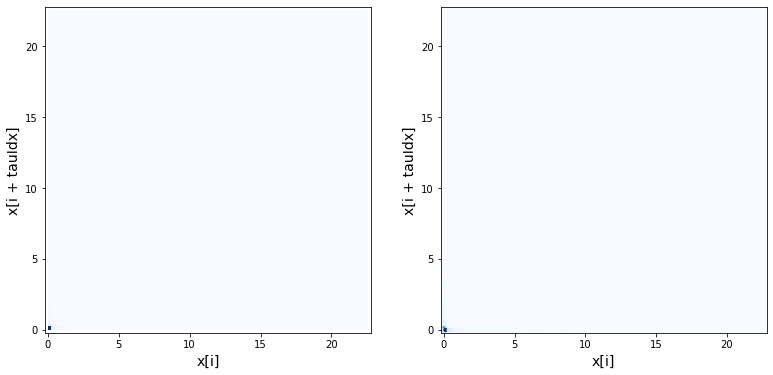

In [92]:
sp.bin2D(x, tauIdx=25)

sp.bin2D(z, tauIdx=35)

[0.02482953 0.02538484 0.02599349 ... 0.02450029 0.02223498 0.02074599]
[0.12643555 0.13298779 0.13942316 ... 0.0232138  0.02423715 0.02538302]


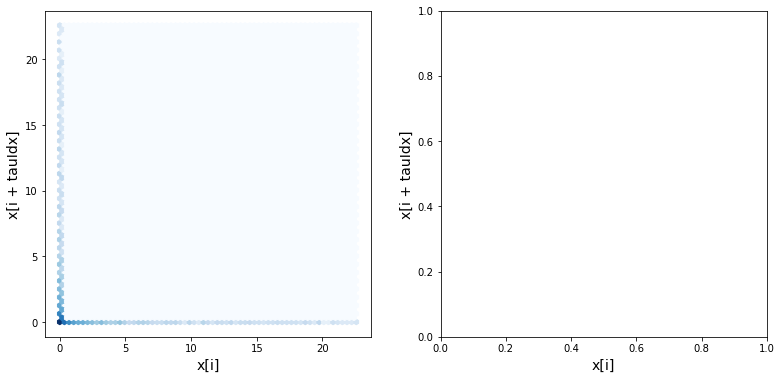

In [97]:
zx = z[:-35]
zy = z[35:]
print(zx)
print(zy)
fig, axes = plt.subplots(1,2,figsize=(13,6))
axes[0].hexbin(zx,zy,bins='log',gridsize=64,cmap="Blues")

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlabel("x[i]",fontsize=14)
    ax.set_ylabel("x[i + tauIdx]",fontsize=14)
    #ax.set_xlim(0,2)
    #ax.set_ylim(0,2)
plt.show()

